## OCNT-DMSLIB-1 DMS Assay Run #2: IFN-beta and varying seeding cell densities

1. [Barcode Sequencing Quality Control](#part1)
2. [Summary Statistics](#part2)
    -  [Within Condition](#part2a)
    -  [Across Conditions](#part2b)
3. [Visualization and Interpretation](#part3) 

In [3]:
library(magrittr)
library(data.table)
library(ggpubr)
library(scales)
library(UpSetR)
library(scico)
library(ggridges)
library(knitr)
library(fs)
library(patchwork)
library(glmmTMB)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

In [3]:
rnabcs <- dir_ls("../pipeline/", glob = "*rna-bcs.tsv")
names(rnabcs) <- gsub("../pipeline/|.rna-bcs.tsv", "", rnabcs, perl = T)

rnabcs <- rnabcs %>% map_dfr(fread, .id = "sample", col.names = c("count", "bc"))

bcs_all <- fread("../pipeline/10.bcmap-join-bcs.tsv", col.names = "bc")
bcs_filt <- fread("../pipeline/10.bcmap-filtered-bcs.tsv", col.names = "bc")

In [4]:
mapped_counts <- fread("../pipeline/10.mapped-counts.tsv") %>%
    separate(oligo, c("lib", "chunk", "wt_aa", "pos",
        "mut_aa", "wt_codon", "mut_codon"), "_") %>%
    group_by(sample) %>%
    mutate(stop_counts = sum(count[which(mut_aa == "*")]) / 1000000)

mapped_counts$mut_aa[which(mapped_counts$wt_aa == mapped_counts$mut_aa | is.na(mapped_counts$mut_aa))] <- "WT" #nolint
mapped_counts$mut_aa <- relevel(as.factor(mapped_counts$mut_aa), ref = "WT")
mapped_counts$condition <- relevel(as.factor(mapped_counts$condition), ref = "none")

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 241410 rows [4, 17, 20, 30, 39, 53, 60, 81, 90, 115, 122, 136, 143, 152, 167, 169, 187, 192, 205, 227, ...].”


In [5]:
rnabcs_groups <- rnabcs %>%
    mutate("filt" = bc %in% bcs_filt$bc,
           "all" = bc %in% bcs_all$bc,
           "final" = bc %in% mapped_counts$barcode,
           "category" = case_when(all & filt & final ~ "perfect",
                                  all & filt ~ "perfect, subthreshold",
                                  all ~ "imperfect, previously observed",
                                  TRUE ~ "not previously observed"))

In [6]:
rnabcs_group_counts <- rnabcs_groups %>%
    select(sample, category, count) %>%
    group_by(sample, category) %>%
    summarize(count = sum(count))

`summarise()` has grouped output by 'sample'. You can override using the `.groups` argument.



### Barcode Sequencing Quality Control <a name="part1"></a>

In this dataset, we assay a set of conditions in triplicate, and the set of conditions included form a tidy 3x3 grid. Thus, we have 3x3x3=27 total samples with the following design:

| Cell Density | Cytokine | Sample Group |
| :--- | :--- | :--- |
| 7 million | None | 1ABC |
| 7 million | IFN-beta | 2ABC |
| 7 million | IFN-alpha | 3ABC |
| 3 million | None | 4ABC |
| 3 million | IFN-beta | 5ABC |
| 3 million | IFN-alpha | 6ABC |
| 1 million | None | 7ABC |
| 1 million | IFN-beta | 8ABC |
| 1 million | IFN-alpha | 9ABC |

We consider IFN-beta analogously to forskolin in the MC4R DMS assays, and use the exact same model evaluated per-position across chunk 10. We can decompose the total depth from each sample into categories based on the barcodes each read originate from:

In [7]:
rnabcs_group_counts %>%
    group_by(sample) %>%
    mutate("total depth" = sum(count)) %>%
    pivot_wider(names_from = "category", values_from = "count") %>%
    relocate(sample, `total depth`, perfect, `perfect, subthreshold`) %>%
    kable()



|sample | total depth|  perfect| perfect, subthreshold| imperfect, previously observed| not previously observed|
|:------|-----------:|--------:|---------------------:|------------------------------:|-----------------------:|
|1A     |    30753237| 18858254|               4642656|                        6307039|                  945288|
|1B     |    31470859| 19216148|               4755362|                        6535706|                  963643|
|1C     |    30750445| 18938478|               4569751|                        6265922|                  976294|
|2A     |    33377984| 20382899|               5089353|                        6919471|                  986261|
|2B     |    34640783| 21097625|               5315695|                        7158793|                 1068670|
|2C     |    34721558| 21182153|               5313254|                        7170219|                 1055932|
|3A     |    37187425| 23737223|               5852696|                        6473273|       

Below, the same table expressed as percentages:

In [8]:
rnabcs_group_counts %>%
    group_by(sample) %>%
    mutate("total depth" = sum(count),
           "count" = count*100 / `total depth`,
           "total depth" = 100) %>%
    pivot_wider(names_from = "category", values_from = "count") %>%
    relocate(sample, `total depth`, perfect, `perfect, subthreshold`) %>%
    kable()



|sample | total depth|  perfect| perfect, subthreshold| imperfect, previously observed| not previously observed|
|:------|-----------:|--------:|---------------------:|------------------------------:|-----------------------:|
|1A     |         100| 61.32120|              15.09648|                       20.50854|                3.073784|
|1B     |         100| 61.06013|              15.11037|                       20.76749|                3.062017|
|1C     |         100| 61.58766|              14.86076|                       20.37669|                3.174894|
|2A     |         100| 61.06690|              15.24763|                       20.73064|                2.954825|
|2B     |         100| 60.90401|              15.34519|                       20.66579|                3.085005|
|2C     |         100| 61.00577|              15.30246|                       20.65063|                3.041142|
|3A     |         100| 63.83132|              15.73837|                       17.40716|       

This is generally consistent with the previously estimated "sequencing + synthesis" error rate of 35%, along with a small fraction (~3.3%) of barcodes which are observed for the first time in the new data. These are probably sequencing errors which occurred in the barcode sequencing data, but were not observed in any prior run.

Now, we consider only those barcodes which are in the `perfect` category in the above tables. Each of these barcodes is attached to a particular oligo, so we can view the spread of how many barcodes are attached to each codon or each amino-acid level sequence:

In [9]:
bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10")

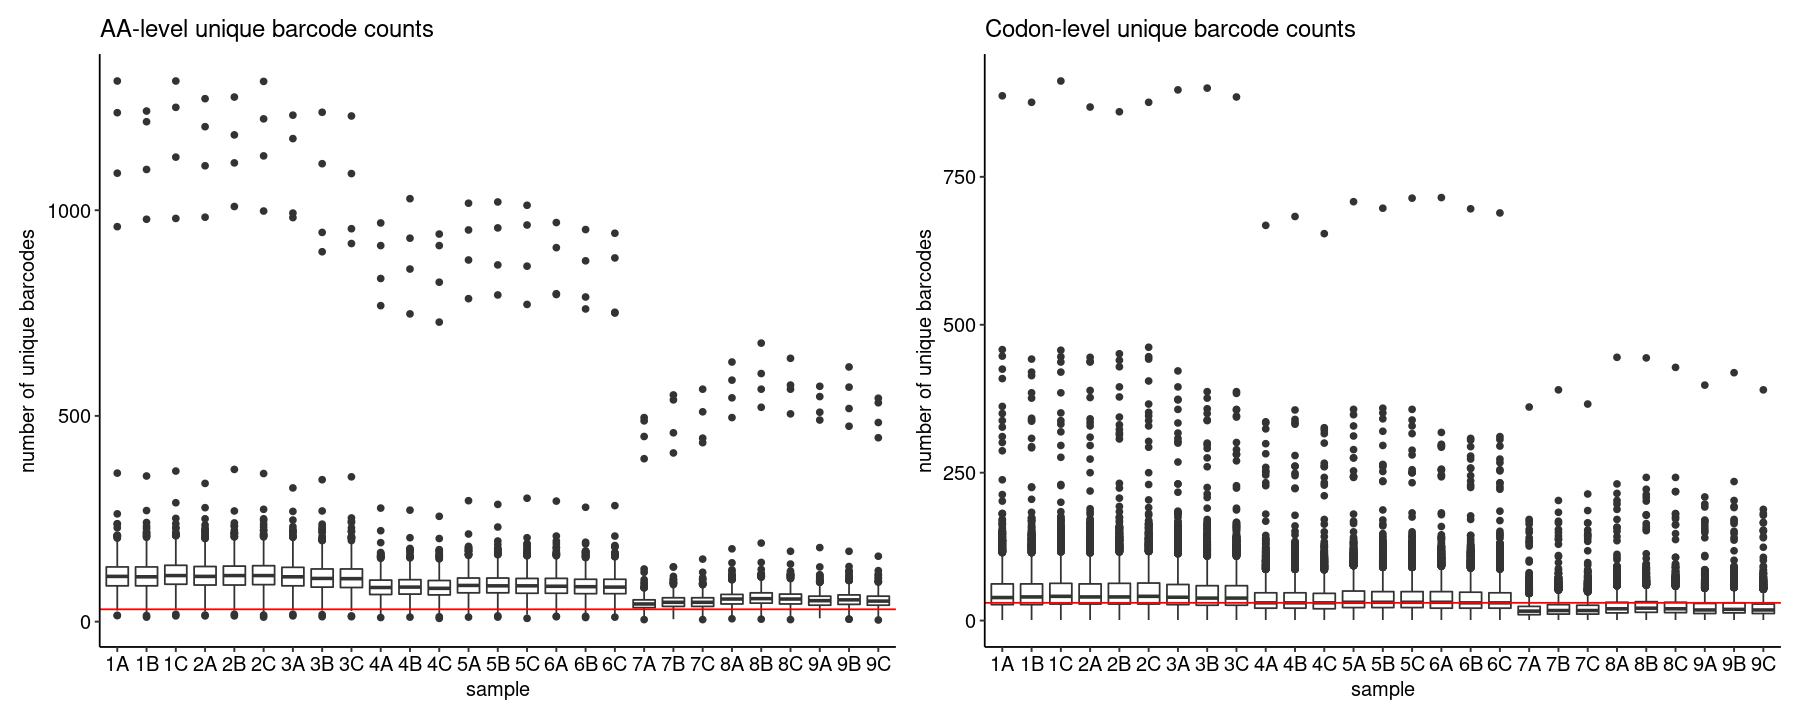

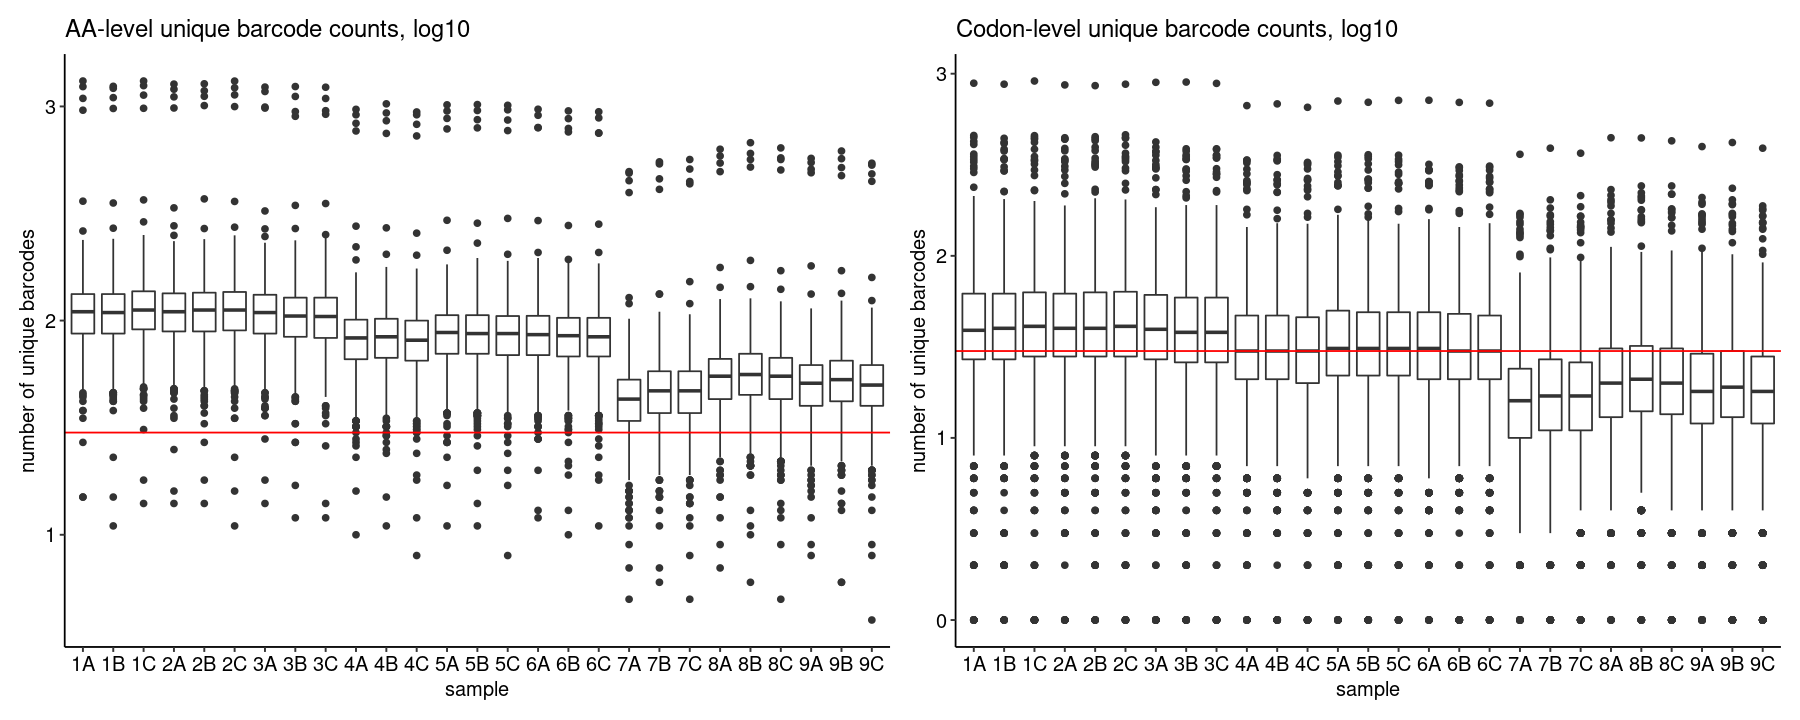

In [10]:
options(repr.plot.width = 15, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

Each of the above points is a particular codon variant or residue variant, and the count is the number of unique barcodes for that variant. We can see the distributions a bit more clearly as a density:

In [15]:
mapped_counts$interval <- cut_interval(log2(mapped_counts$count), length = 0.5)
cell_densities <- tibble("sample" = unique(mapped_counts$sample),
                         "density" = c(rep("7 million",9), rep("3 million",9), rep("1 million", 9)))
col <- c("7 million" = "red", "3 million" = "blue", "1 million" = "magenta")

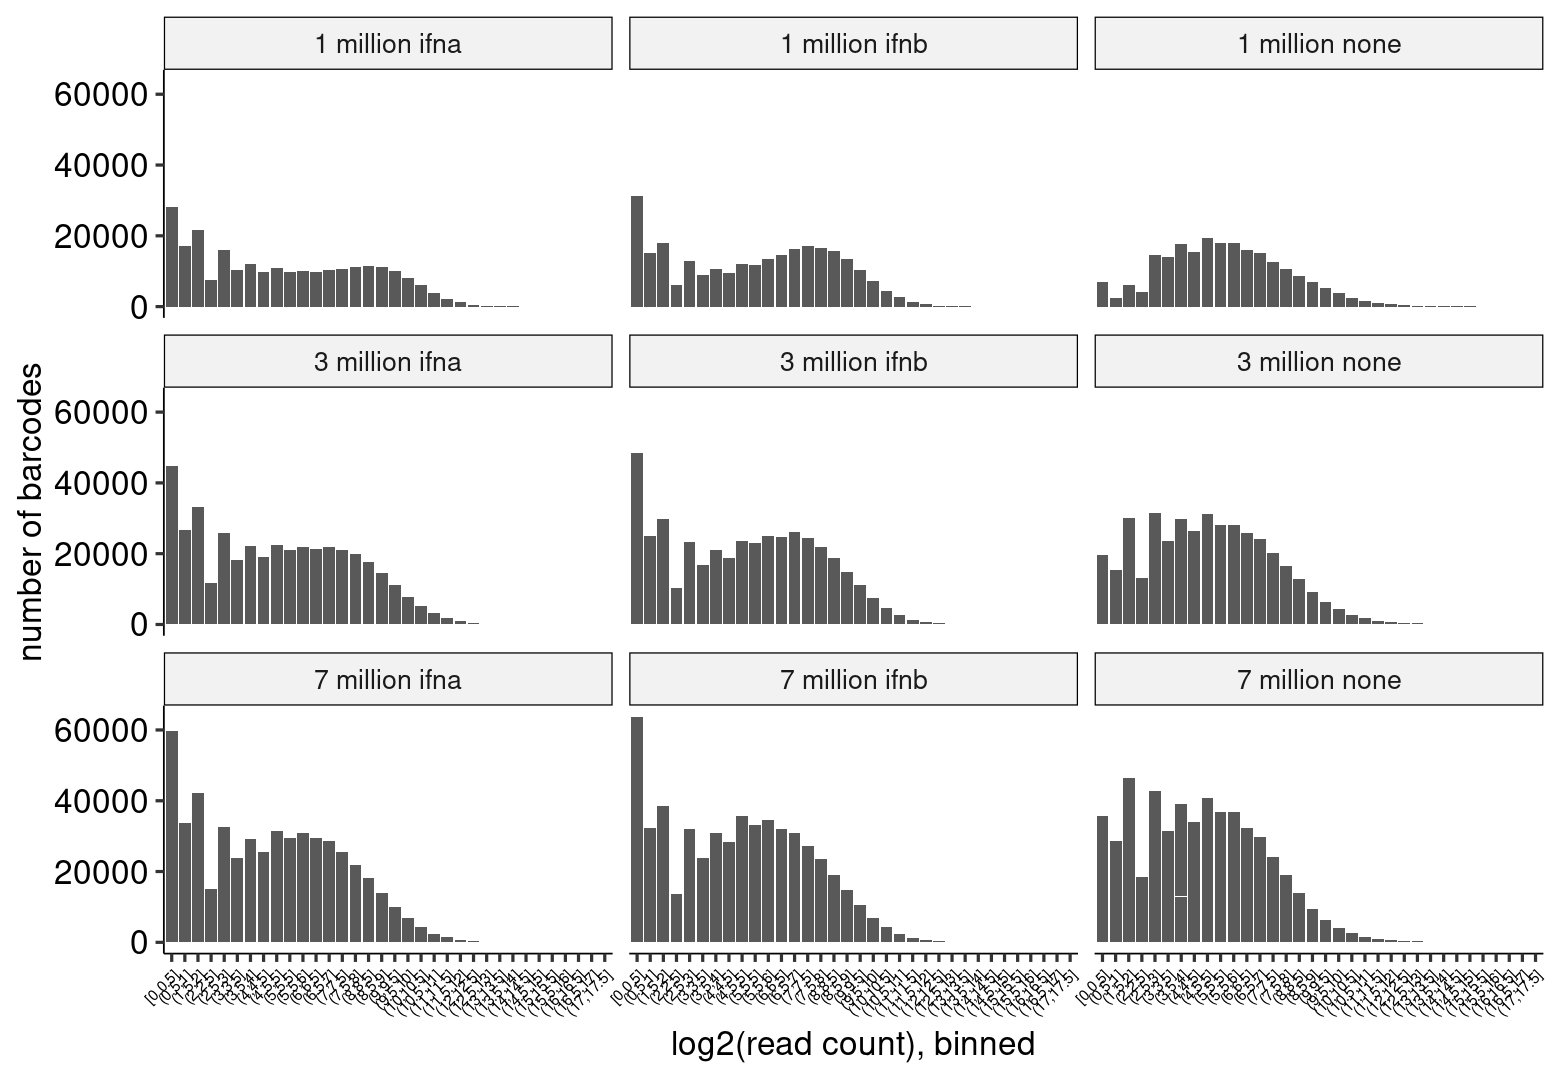

In [36]:
options(repr.plot.width = 13, repr.plot.height = 9)
mapped_counts %>%
    left_join(cell_densities, by = "sample") %>%
    count(density, interval, condition, sample) %>%
    ggplot() +
        geom_bar(aes(x = interval, y = n), stat = "identity") +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        facet_wrap(~paste0(density, " ", condition)) +
        theme(axis.text.x = element_text(size = 9)) +
        xlab("log2(read count), binned") +
        ylab("number of barcodes")

Note that while these barcodes have only one read count in a given sample in the 1x26 dataset, the fact that it is in the barcode map means it was detected in at least two sequencing replicates with at least three reads each in the barcode mapping data. Nonetheless, we can verify that we still would have enough barcode coverage even if we removed "lowly expressed" barcodes - again, we will not do this for the actual analysis, but we can just check:

In [27]:
bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT" & count >= 4) %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT" & count >= 4) %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, \nread count >= 4")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, \nread count >= 4")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10, \nread count >= 4")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10, \nread count >= 4")

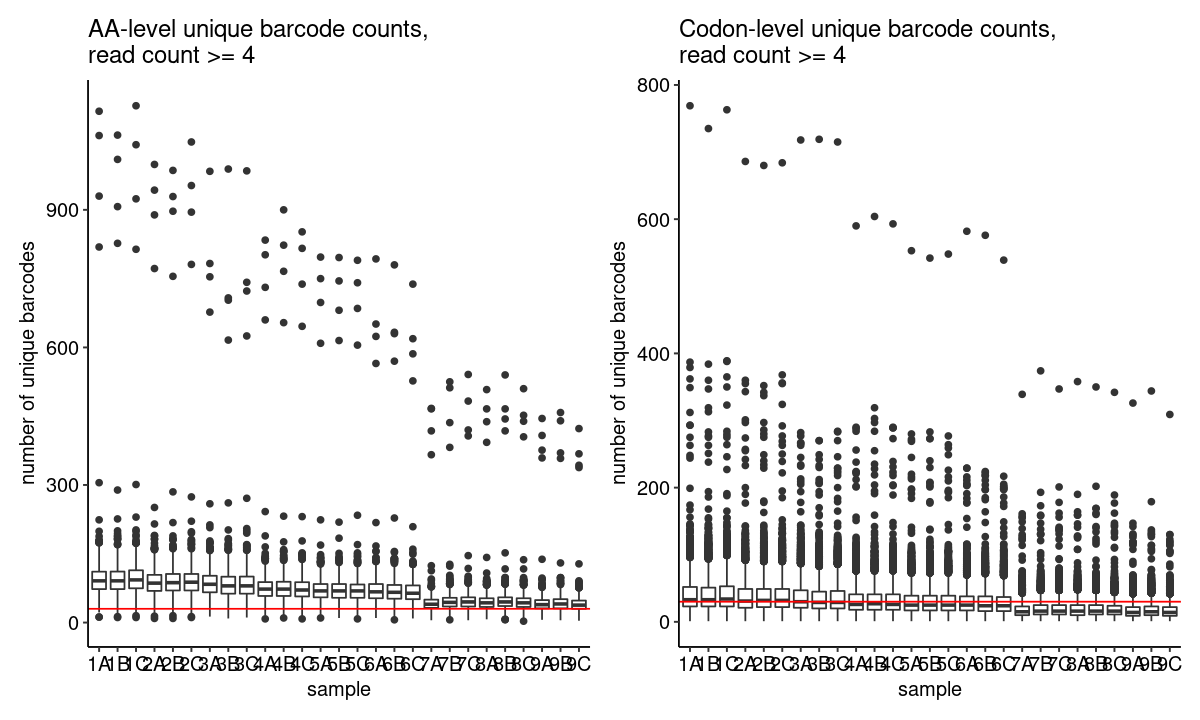

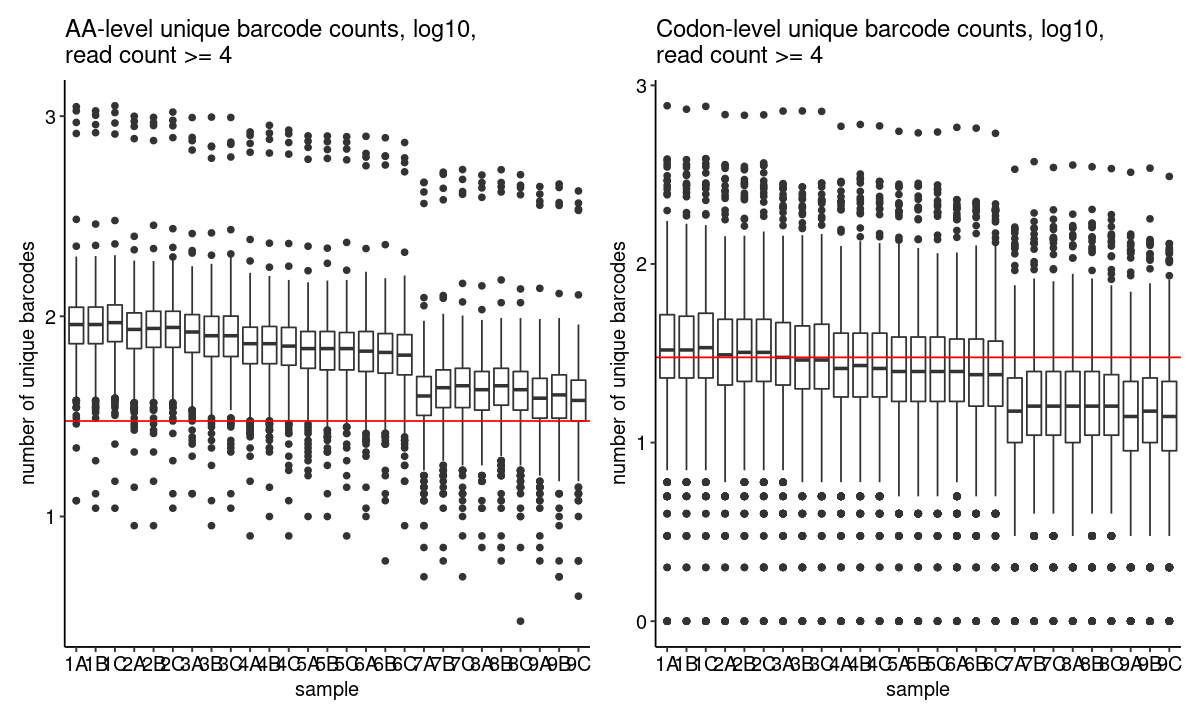

In [28]:
options(repr.plot.width = 10, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

We can also assess coverage by plotting the numbers of barcodes per variant across each amino acid. Since the samples are fairly similar

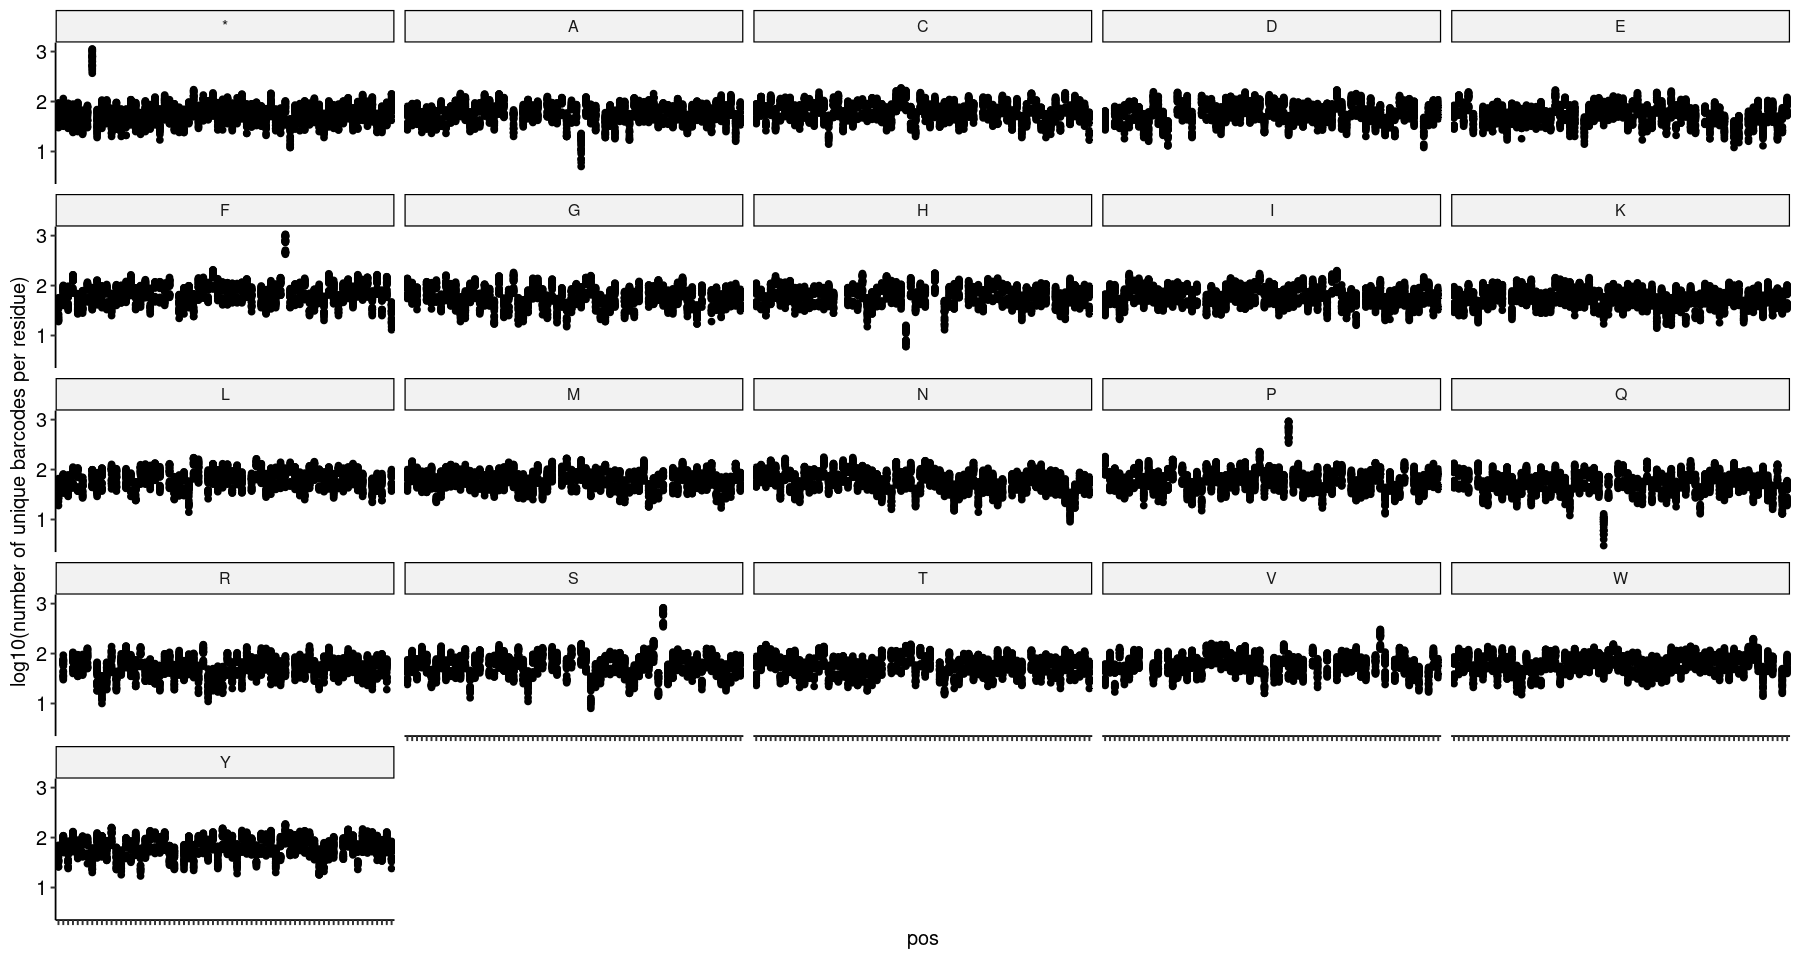

In [29]:
options(repr.plot.width = 15, repr.plot.height = 8)
ggplot(bc_counts_aa) +
    geom_point(aes(x = pos, y = log10(n))) +
    facet_wrap(~mut_aa) +
    theme_pubr() +
    theme(axis.text.x = element_blank()) + ylab("log10(number of unique barcodes per residue)")

If we collapse these counts into bars, we see the approximate effects of changing the number of assayed cells on total barcode diversity:

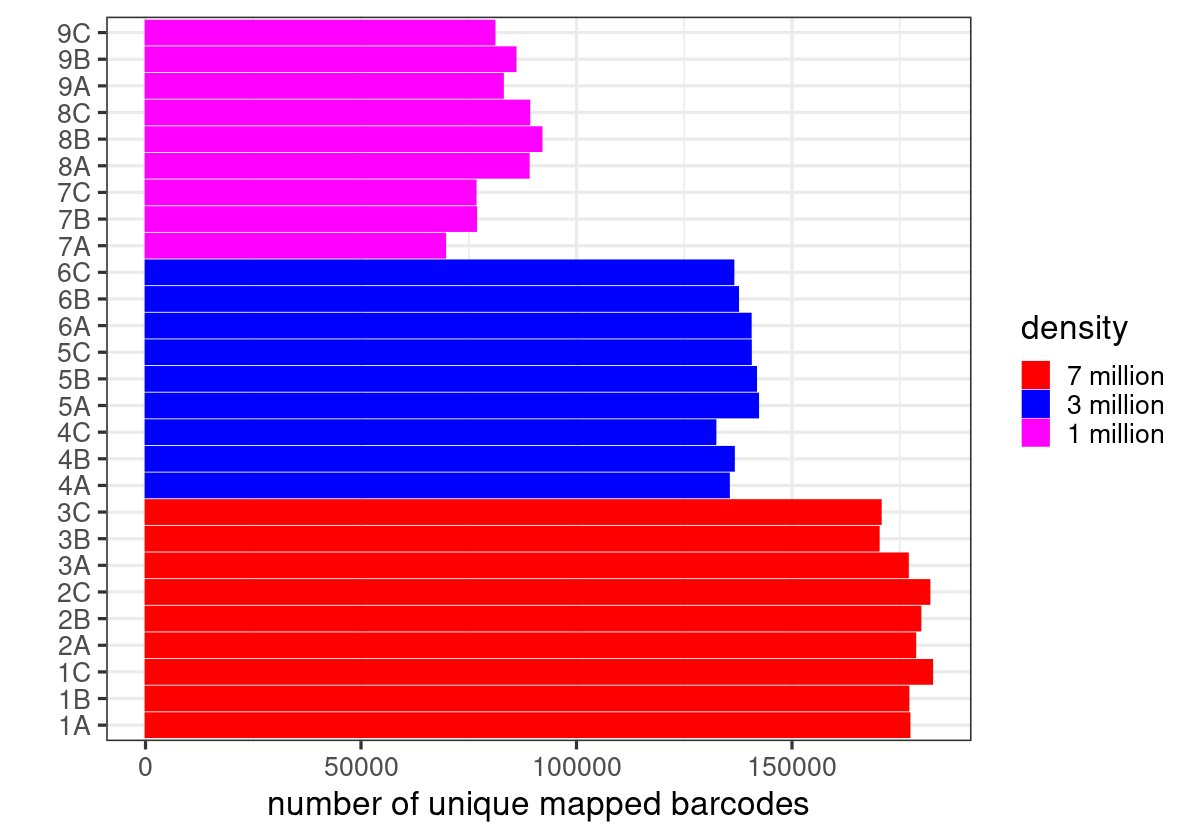

In [35]:
options(repr.plot.width = 10, repr.plot.height = 7)
mapped_counts %>%
    left_join(cell_densities, by = "sample") %>%
    count(sample, density) %>%
    ggplot() +
        geom_bar(aes(x = sample, y = n, color = density, fill = density), stat = "identity") +
        theme_bw(base_size = 20) +
        scale_color_manual(values = col) +
        scale_fill_manual(values = col) +
        coord_flip() +
        xlab("") +
        ylab("number of unique mapped barcodes")

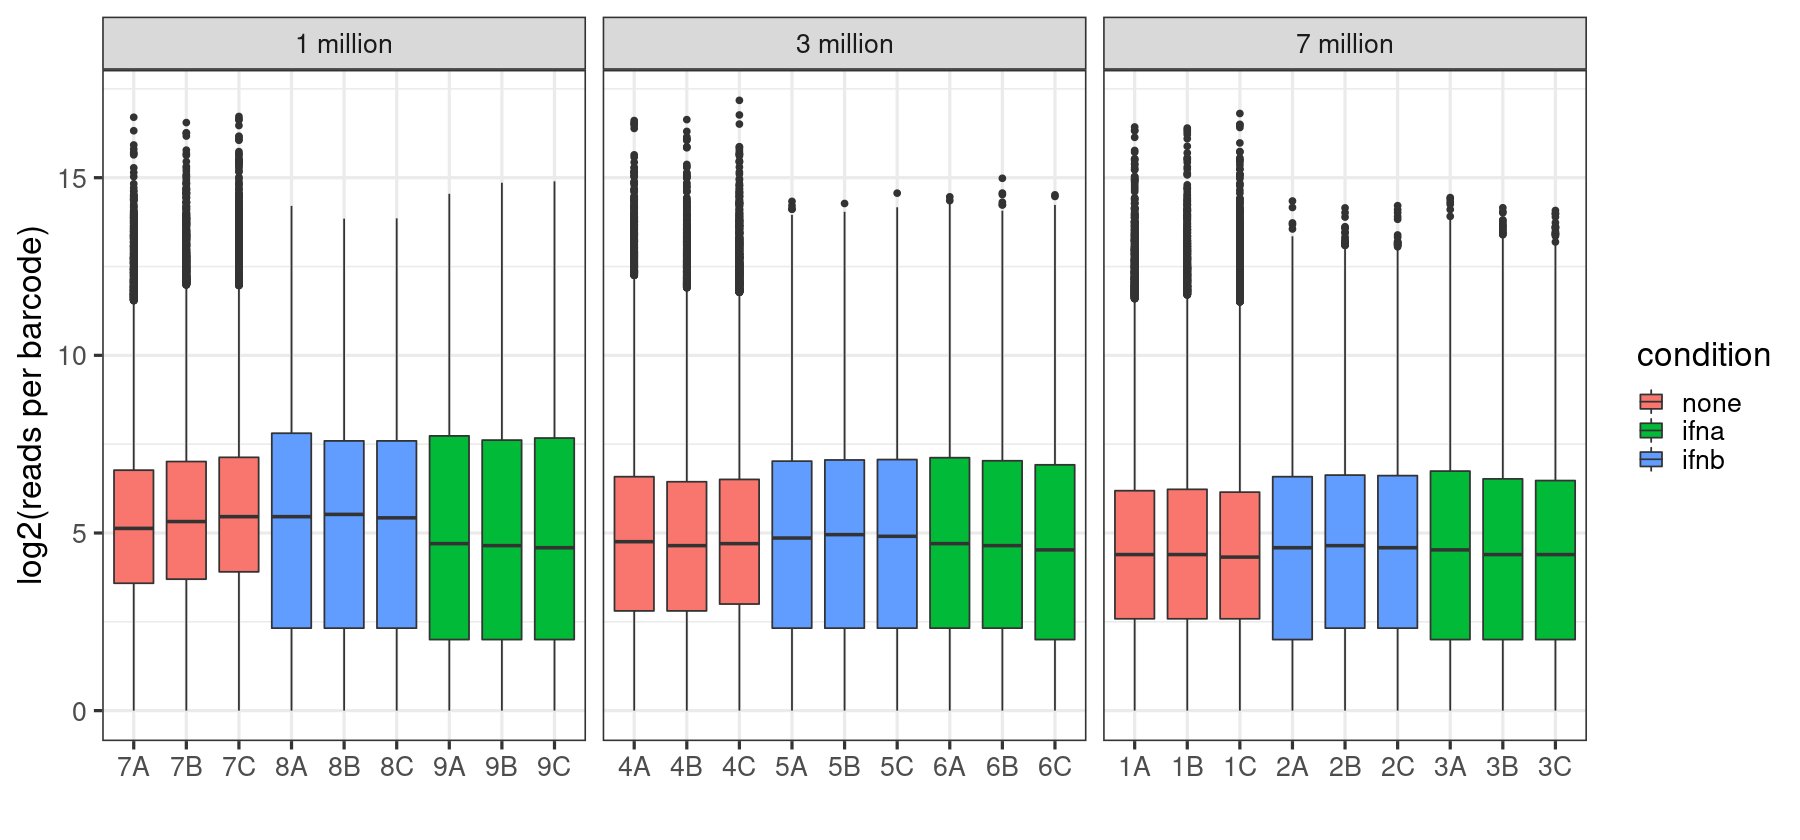

In [34]:
options(repr.plot.width = 15, repr.plot.height = 7)

mapped_counts %>%
    left_join(cell_densities, by = "sample") %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log2(count), fill = condition)) +
        theme_bw(base_size = 20) +
        xlab("") + ylab("log2(reads per barcode)") +
        facet_wrap(~density, scales = "free_x")

### Summary Statistics <a name="part2"></a>

Like for MC4R, we have a forskolin-like condition (IFNb), our main stimulatory condition (IFNa), and a none-like condition (none!). We can apply the same hierarchical mixed model to jointly infer mutant vs WT effects within each of these three conditions, and then compute the change in variant impact (the fold change of fold changes) across conditions. We start by considering the primary mutant vs WT effects within each treatment (IFNa, IFNb, or None) and seeing how many significant hits we detect in each at a 1% FDR:

#### Within Condition <a name="part2a"></a>

In [4]:
files <- dir_ls("../sumstats/", glob = "*mil-separated*tsv")
names(files) <- gsub("../sumstats/10-|-separated.sumstats.tsv","",files)
sumstats <- files %>% map_dfr(read_tsv, .id = "density") %>%
    mutate(term = gsub("mut_aa","",term))

Rows: 4410 Columns: 10

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): clone, condition, term, version
dbl (6): pos, chunk, estimate, std.error, statistic, p.value


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 4410 Columns: 10

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): clone, condition, term, version
dbl (6): pos, chunk, estimate, std.error, statistic, p.value


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 4410 Columns: 10

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): clone, condition, term, version
dbl (6): pos, chunk, estimate, std.error, statistic, p.value


ℹ Use `spec()` 

In [131]:
sumstats_wt <- sumstats %>% 
    filter(term == "WT") %>%
    select(density, pos, condition, estimate_wt = estimate, std.error_wt = std.error)

sumstats_primary <- sumstats %>% 
    filter(term != "WT") %>%
    select(density, pos, condition, term, estimate, std.error) %>%
    left_join(sumstats_wt) %>%
    mutate(estimate = estimate - estimate_wt,
       std.error = sqrt(std.error^2 + std.error_wt^2),
       statistic = estimate / std.error,
       p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                         (1-pnorm(statistic, sd = 1))*2))

Joining, by = c("density", "pos", "condition")



In [137]:
sumstat_sig <- sumstats_primary %>%
    group_by(density, condition) %>%
    mutate(p.adj = p.adjust(p.value, method = "BH"),
           nom_sig = if_else(p.value <= 1e-2, "significant", "nonsignificant"),
           adj_sig = if_else(p.adj <= 1e-2, "significant", "nonsignificant"))

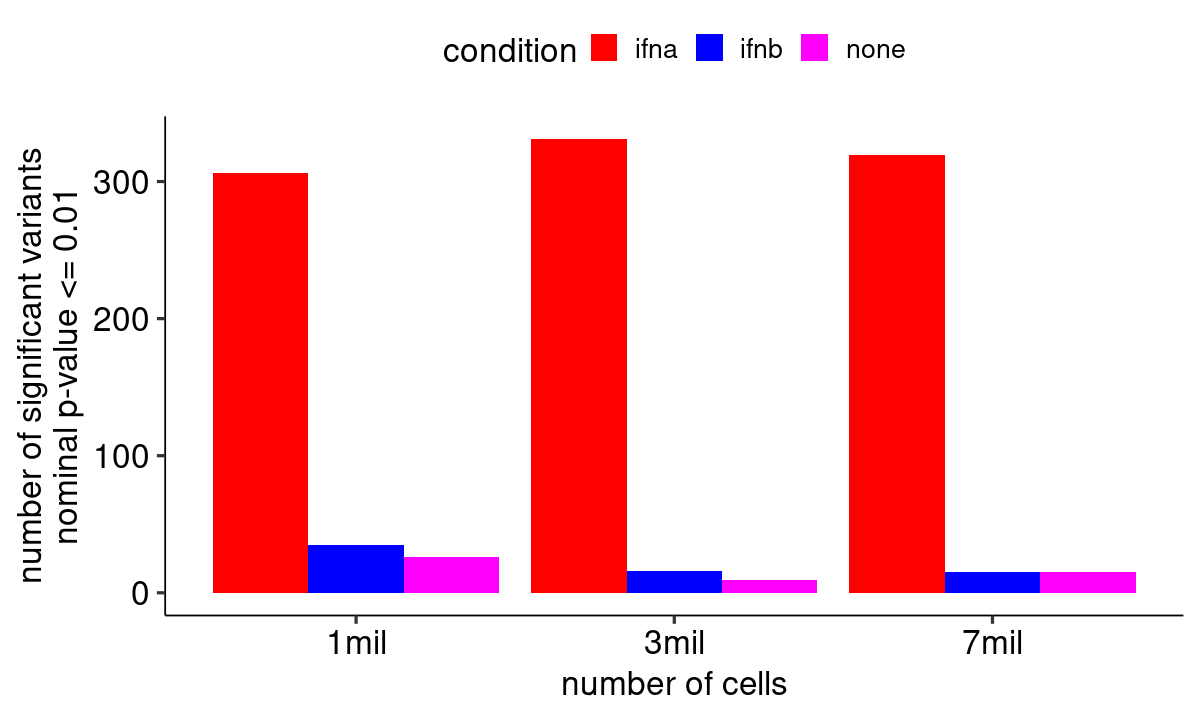

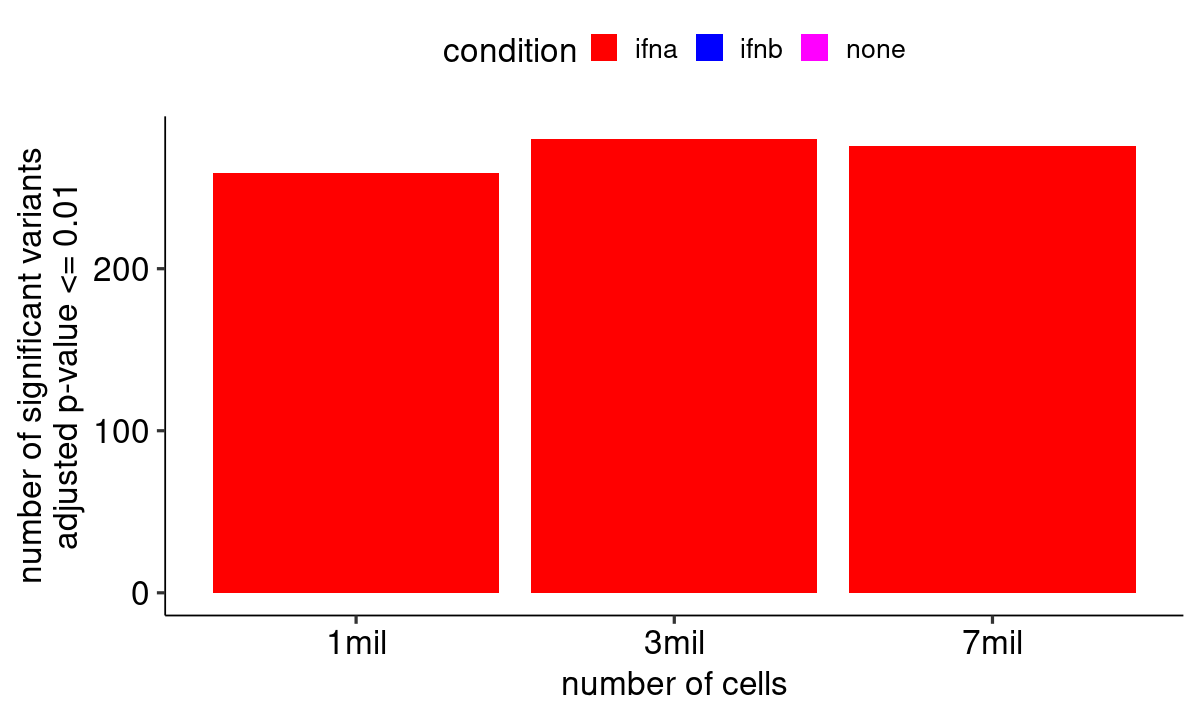

In [133]:
options(repr.plot.width = 10, repr.plot.height = 6)
sumstat_sig %>%
    count(density, condition, nom_sig) %>%
    filter(nom_sig == "significant") %>%
    ggplot() +
        geom_bar(aes(x = density, y = n, fill = condition), stat = "identity", position = position_dodge()) +
        theme_pubr(base_size = 20) +
        scale_fill_manual(values = c("ifna" = "red", "ifnb" = "blue", "none" = "magenta")) +
        xlab("number of cells") + ylab("number of significant variants\nnominal p-value <= 0.01")

sumstat_sig %>%
    count(density, condition, adj_sig) %>%
    filter(adj_sig == "significant") %>%
    ggplot() +
        geom_bar(aes(x = density, y = n, fill = condition), stat = "identity", position = position_dodge()) +
        theme_pubr(base_size = 20) +
        scale_fill_manual(values = c("ifna" = "red", "ifnb" = "blue", "none" = "magenta")) +
        xlab("number of cells") + ylab("number of significant variants\nadjusted p-value <= 0.01")

We can extract the summary statistics for the stop codons to get a sense of the effect of cell density on stop signal:

Picking joint bandwidth of 0.477

Picking joint bandwidth of 0.297

Picking joint bandwidth of 0.301



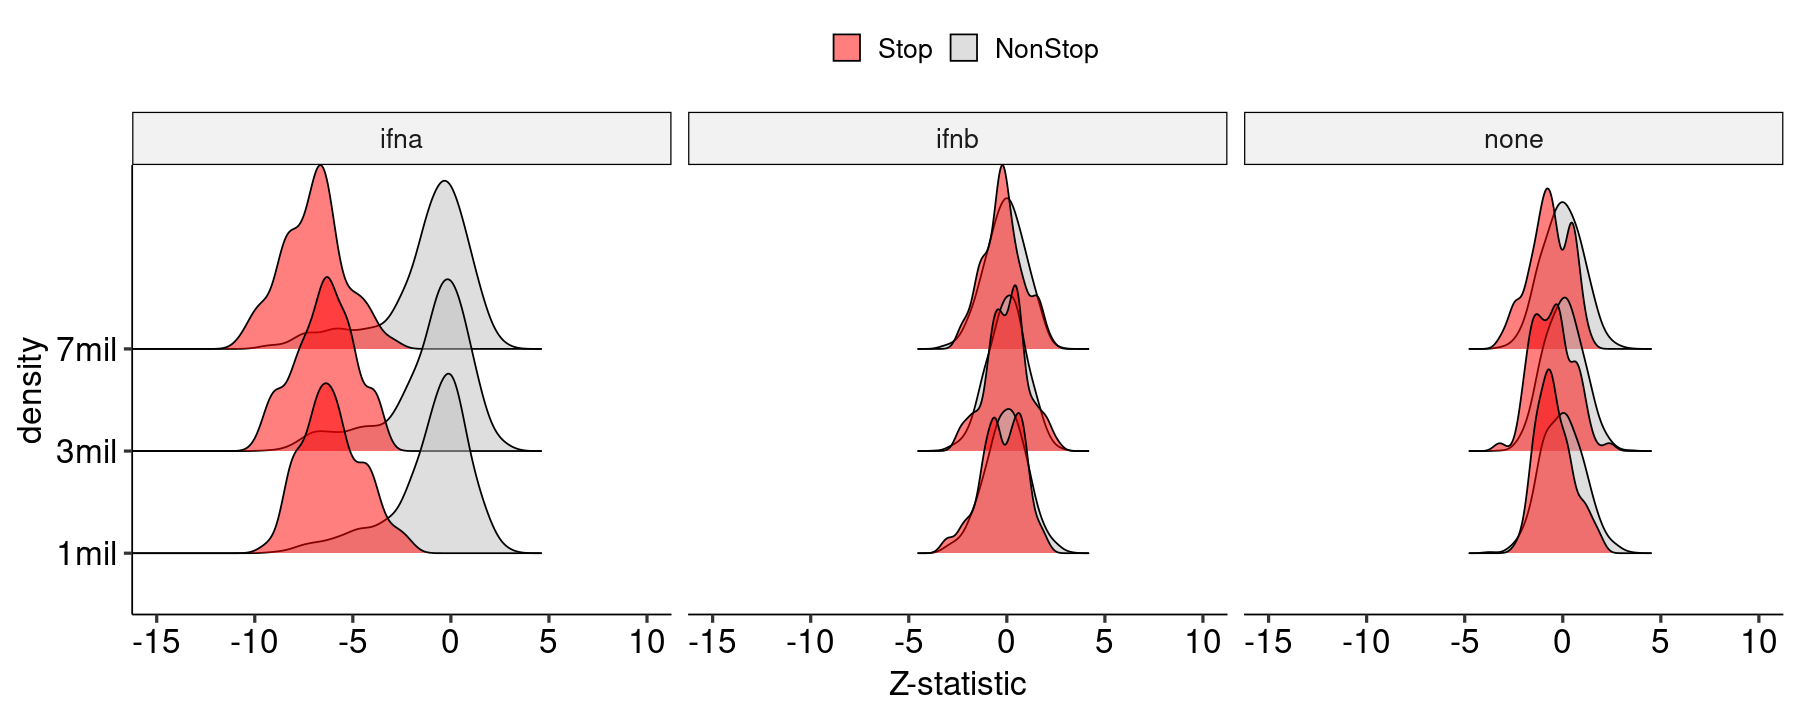

In [135]:
options(repr.plot.width = 15, repr.plot.height = 6)
sumstat_sig %>%
    ggplot() +
        geom_density_ridges(aes(x = statistic, y = density,
                                fill = if_else(term == "*", "Stop", "NonStop")), alpha = 0.5) +
        theme_pubr(base_size = 20) +
        coord_cartesian(xlim = c(-15,10)) +
        scale_fill_manual(values = c("Stop" = "red", "NonStop" = "gray")) +
        theme(legend.title = element_blank()) +
        xlab("Z-statistic") +
        facet_wrap(~condition)

#### Across Conditions <a name="part2b"></a>

We can also generate the same plots for the differences between pairs of these conditions:

In [8]:
files <- dir_ls("../sumstats/", glob = "*mil-nonone-combined*tsv")
names(files) <- gsub("../sumstats/10-|-nonone-combined.sumstats.tsv","",files)
sumstats_comb <- files %>% map_dfr(read_tsv, .id = "density") %>%
    separate(term, c("condition", "mut_aa"), ":") %>%
    mutate(condition = gsub("condition", "", condition),
           mut_aa = gsub("mut_aa", "", mut_aa))
sumstats_alpha <- sumstats_comb %>%
    select(density, pos, condition, mut_aa, estimate, std.error) %>%
    pivot_wider(names_from = "condition", values_from = c("estimate", "std.error"))

files <- dir_ls("../sumstats/", glob = "*mil-noifna-combined*tsv")
names(files) <- gsub("../sumstats/10-|-noifna-combined.sumstats.tsv","",files)
sumstats_comb <- files %>% map_dfr(read_tsv, .id = "density") %>%
    separate(term, c("condition", "mut_aa"), ":") %>%
    mutate(condition = gsub("condition", "", condition),
           mut_aa = gsub("mut_aa", "", mut_aa))
sumstats_none <- sumstats_comb %>%
    select(density, pos, condition, mut_aa, estimate, std.error) %>%
    pivot_wider(names_from = "condition", values_from = c("estimate", "std.error"))

Rows: 2800 Columns: 9

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): clone, term, version
dbl (6): pos, chunk, estimate, std.error, statistic, p.value


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 2800 Columns: 9

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): clone, term, version
dbl (6): pos, chunk, estimate, std.error, statistic, p.value


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 2800 Columns: 9

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): clone, term, version
dbl (6): pos, chunk, estimate, std.error, statistic, p.value


ℹ Use `spec()` to retrieve the full column specific

In [13]:
sumstats_alpha_norm <- sumstats_alpha %>%
    mutate(estimate = estimate_ifna - estimate_ifnb,
           std.error = sqrt(std.error_ifna^2 + std.error_ifnb^2),
           statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

sumstats_none_norm <- sumstats_none %>%
    mutate(estimate = estimate_none - estimate_ifnb,
           std.error = sqrt(std.error_none^2 + std.error_ifnb^2),
           statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

In [14]:
none_norm <- sumstats_alpha_norm %>%
    ggplot() +
        geom_density_ridges(aes(x = statistic, y = density,
                                fill = if_else(mut_aa == "*", "Stop", "NonStop")), alpha = 0.5) +
        theme_pubr(base_size = 20) +
        coord_cartesian(xlim = c(-15,10)) +
        scale_fill_manual(values = c("Stop" = "red", "NonStop" = "gray")) +
        theme(legend.title = element_blank()) +
        xlab("Z-statistic") +
        ggtitle("IFNa Minus IFNb")

beta_norm <- sumstats_none_norm %>%
    ggplot() +
        geom_density_ridges(aes(x = statistic, y = density,
                                fill = if_else(mut_aa == "*", "Stop", "NonStop")), alpha = 0.5) +
        theme_pubr(base_size = 20) +
        coord_cartesian(xlim = c(-15,10)) +
        scale_fill_manual(values = c("Stop" = "red", "NonStop" = "gray")) +
        theme(legend.title = element_blank()) +
        xlab("Z-statistic") +
        ggtitle("None Minus IFNb")


Picking joint bandwidth of 0.401

Picking joint bandwidth of 0.231



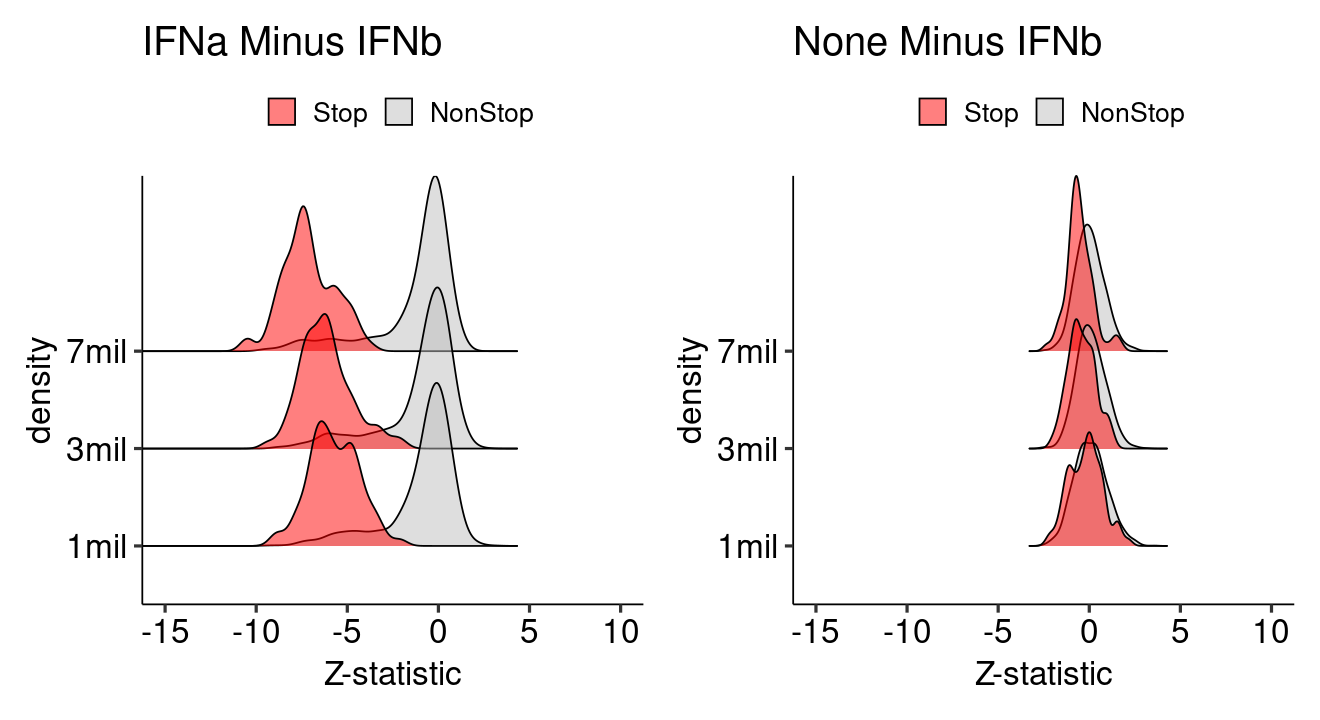

In [27]:
options(repr.plot.width = 11, repr.plot.height = 6)
none_norm + beta_norm

Finally, we can compute the final difference: of (IFNa - IFNb) vs (None - IFNb). This comparison does not _quite_ simplify to (IFNa - None) only because different barcodes are shared or non-shared amongst different sample groups. This returns the following final comparison:

Picking joint bandwidth of 0.278



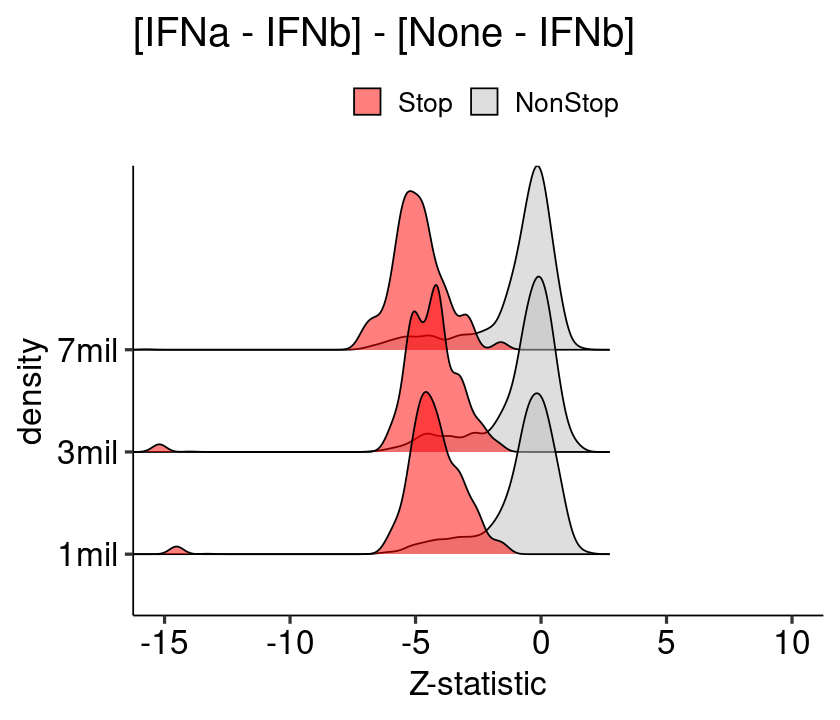

In [29]:
sumstats_final_norm <- bind_rows(sumstats_alpha_norm %>% mutate(group = "alpha"),
          sumstats_none_norm %>% mutate(group = "none")) %>%
    select(density, pos, mut_aa, estimate, std.error, group) %>%
    pivot_wider(names_from = group, values_from = estimate:std.error) %>%
    mutate(estimate = estimate_alpha - estimate_none,
           std.error = sqrt(std.error_alpha^2 + std.error_none^2),
           statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

options(repr.plot.width = 7, repr.plot.height = 6)
ggplot(sumstats_final_norm) +
        geom_density_ridges(aes(x = statistic, y = density,
                                fill = if_else(mut_aa == "*", "Stop", "NonStop")), alpha = 0.5) +
        theme_pubr(base_size = 20) +
        coord_cartesian(xlim = c(-15,10)) +
        scale_fill_manual(values = c("Stop" = "red", "NonStop" = "gray")) +
        theme(legend.title = element_blank()) +
        xlab("Z-statistic") +
        ggtitle("[IFNa - IFNb] - [None - IFNb]")

### Visualization and Interpretation <a name="part3"></a>

Finally, we can make the traditional heatmaps for each of the above comparisons. For IFNa, this will hopefully look pretty similar to the last assay, but we can also see what the IFNb-based signals look like:

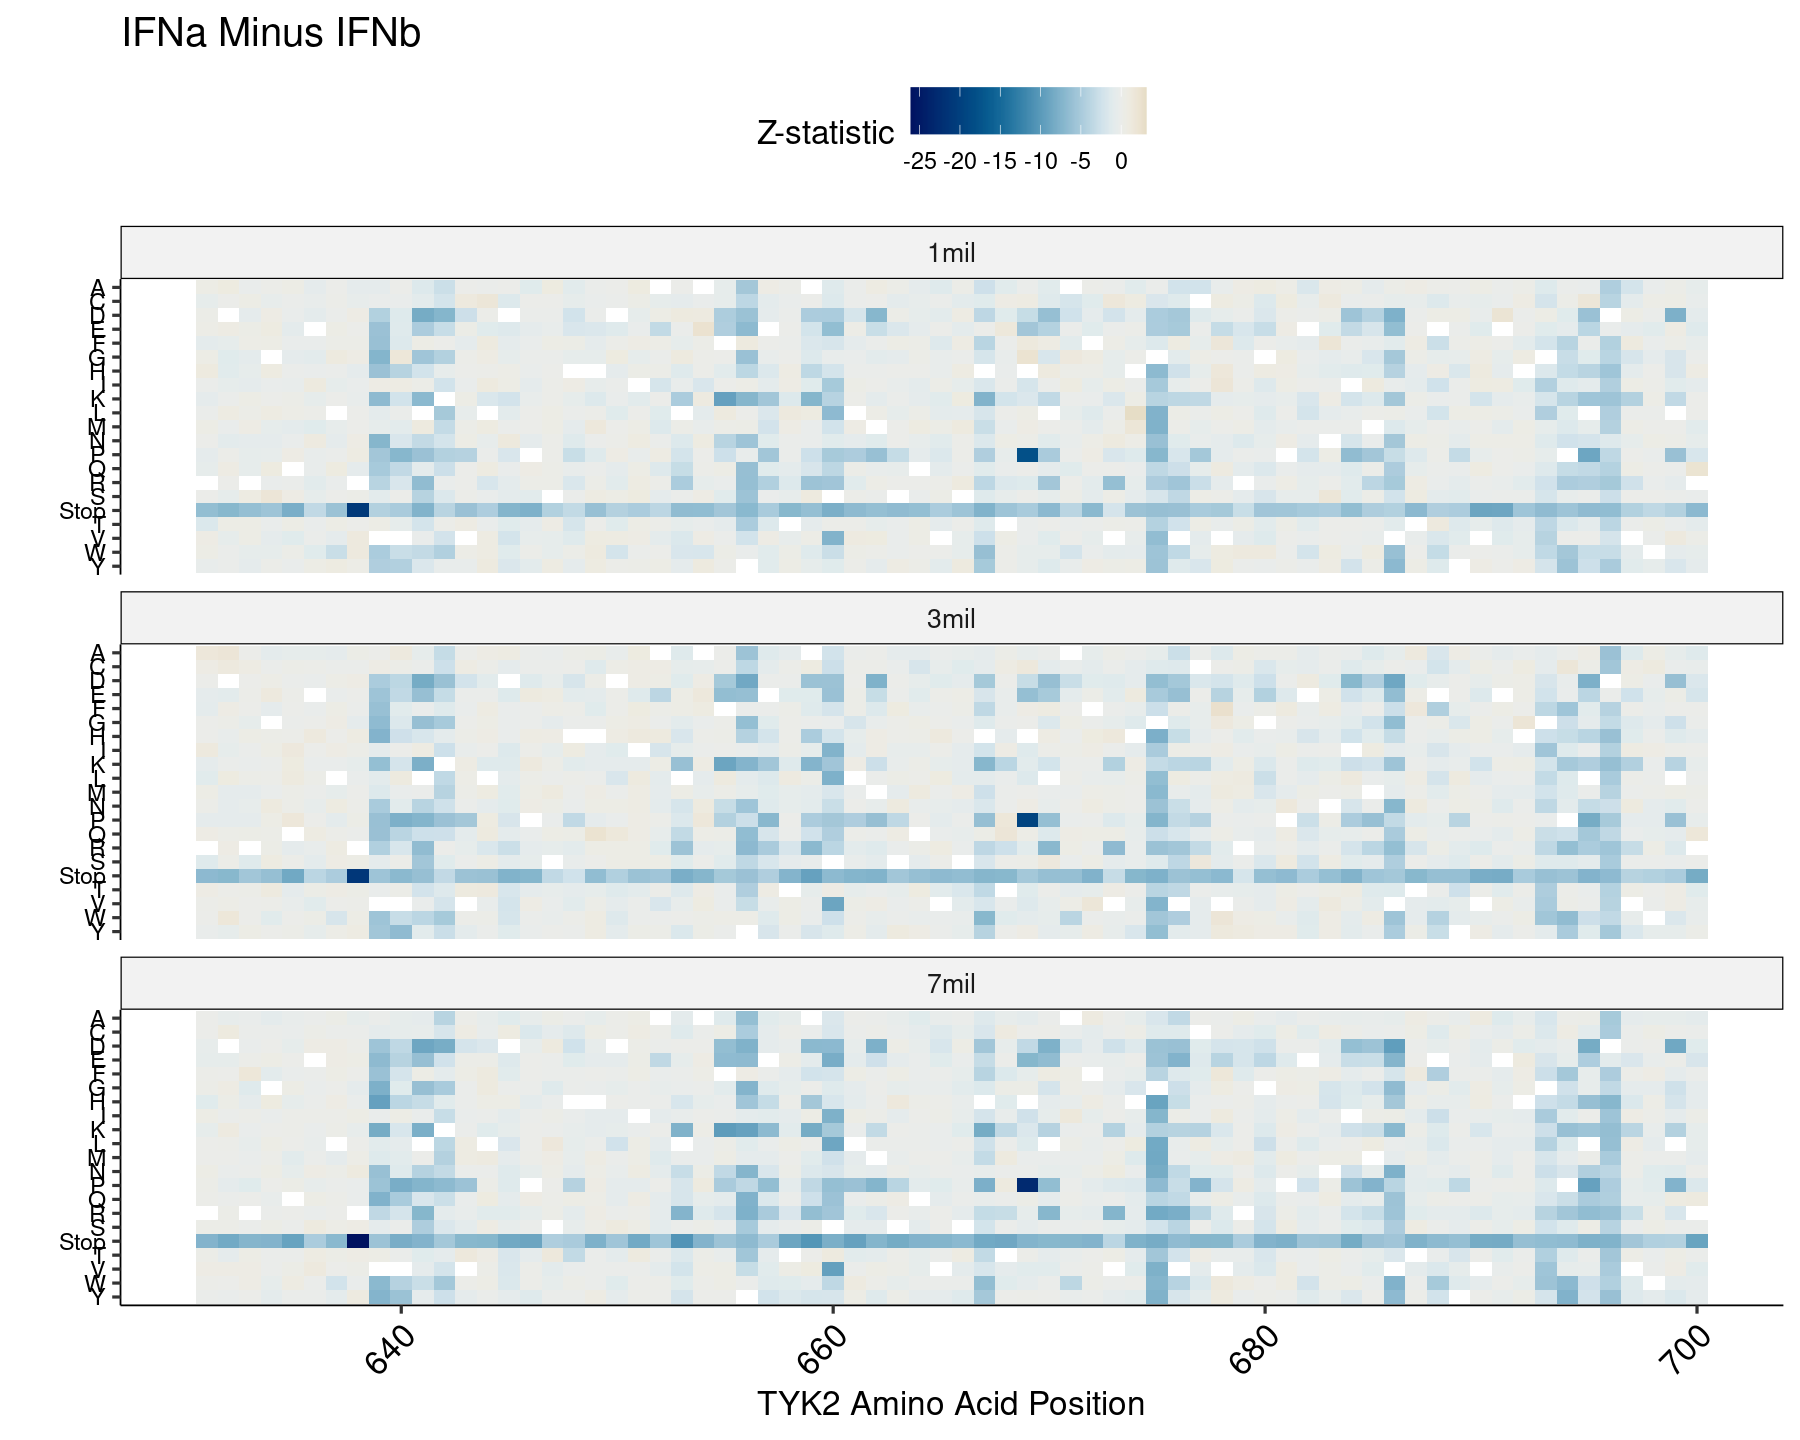

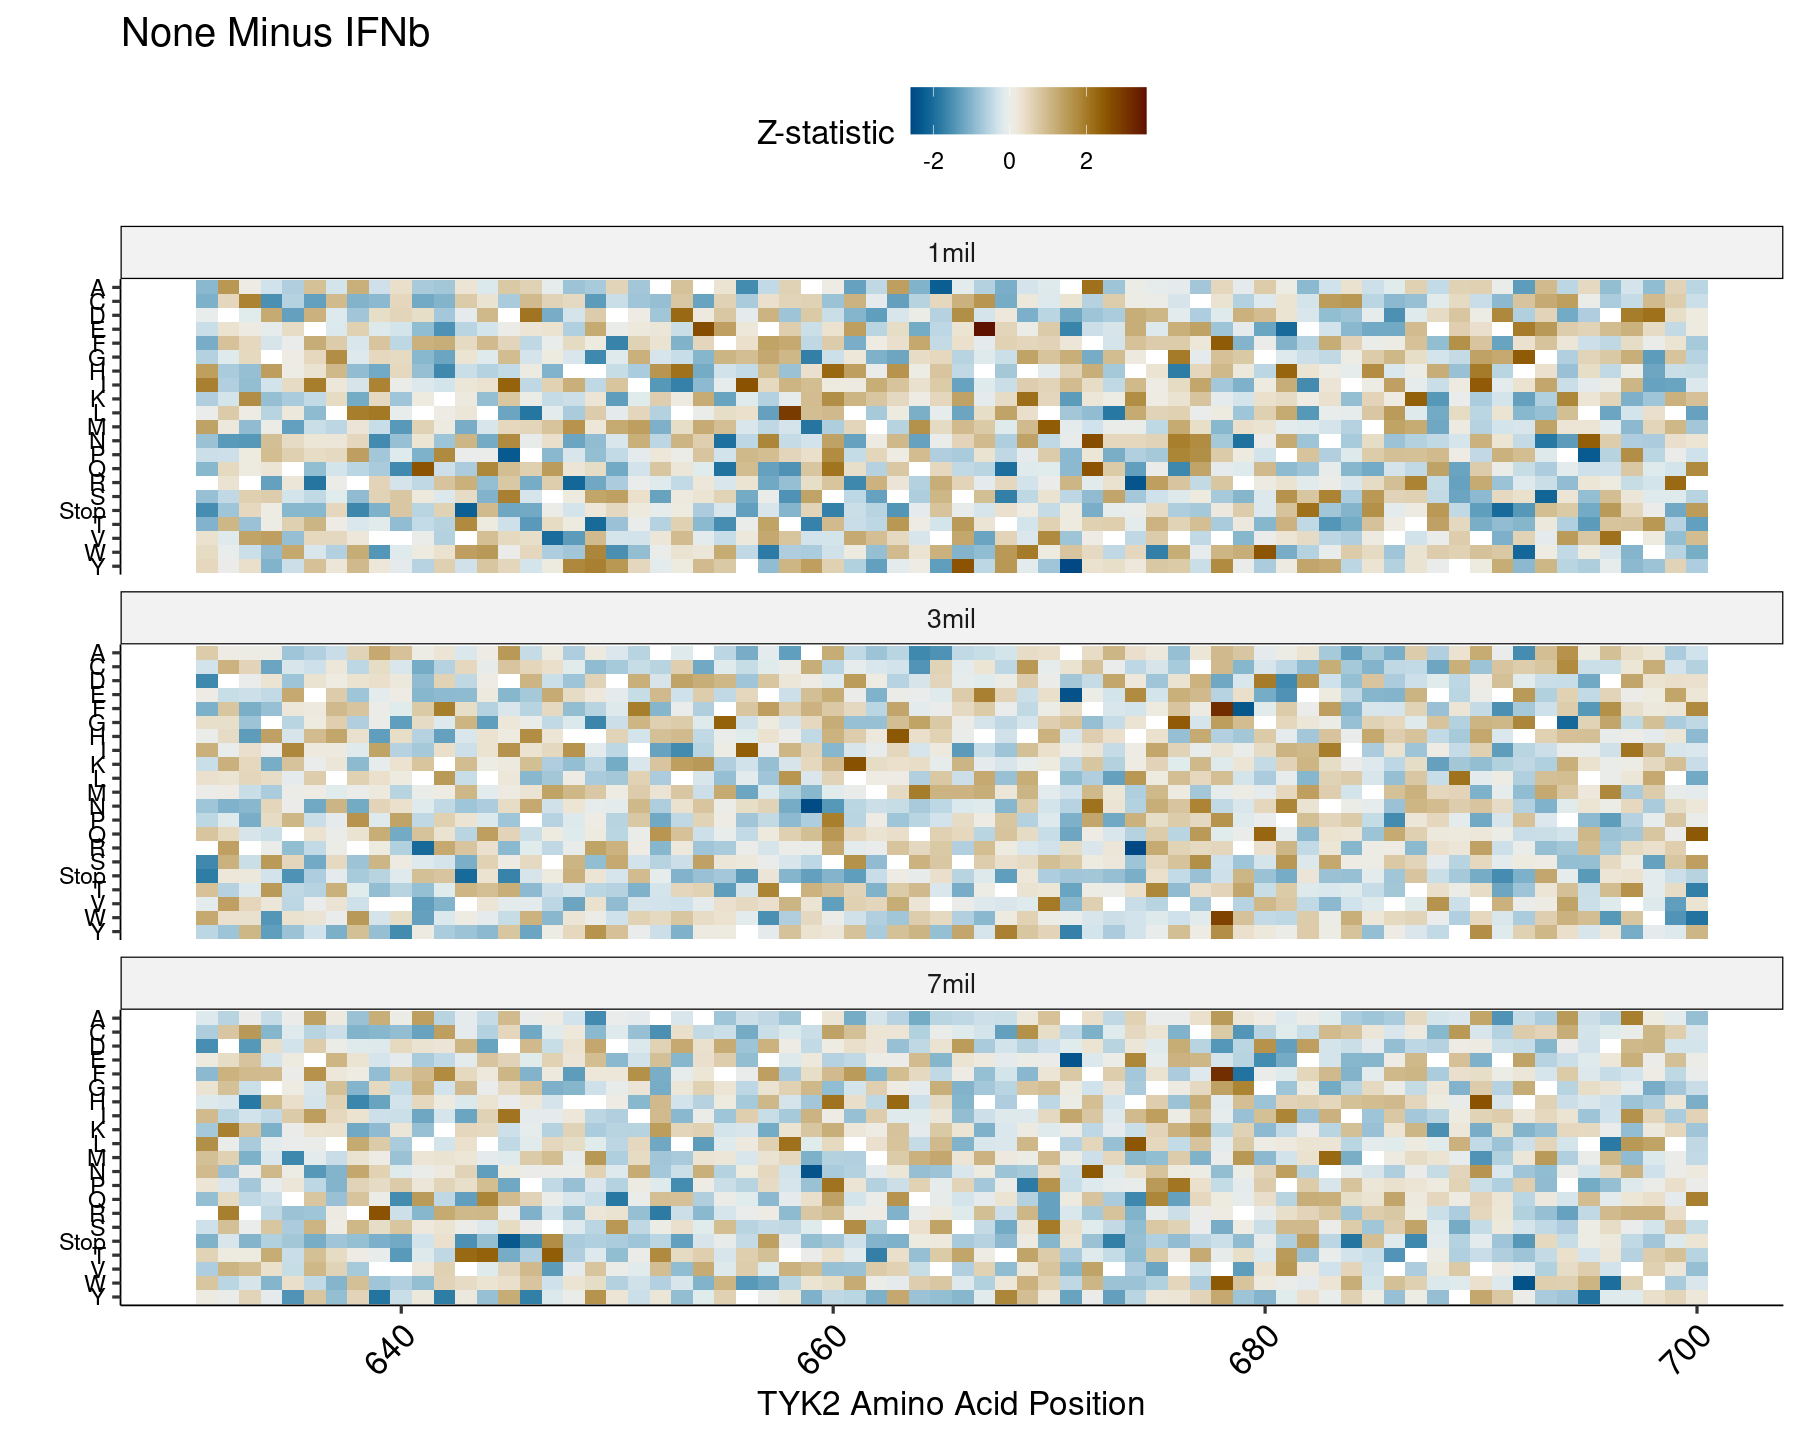

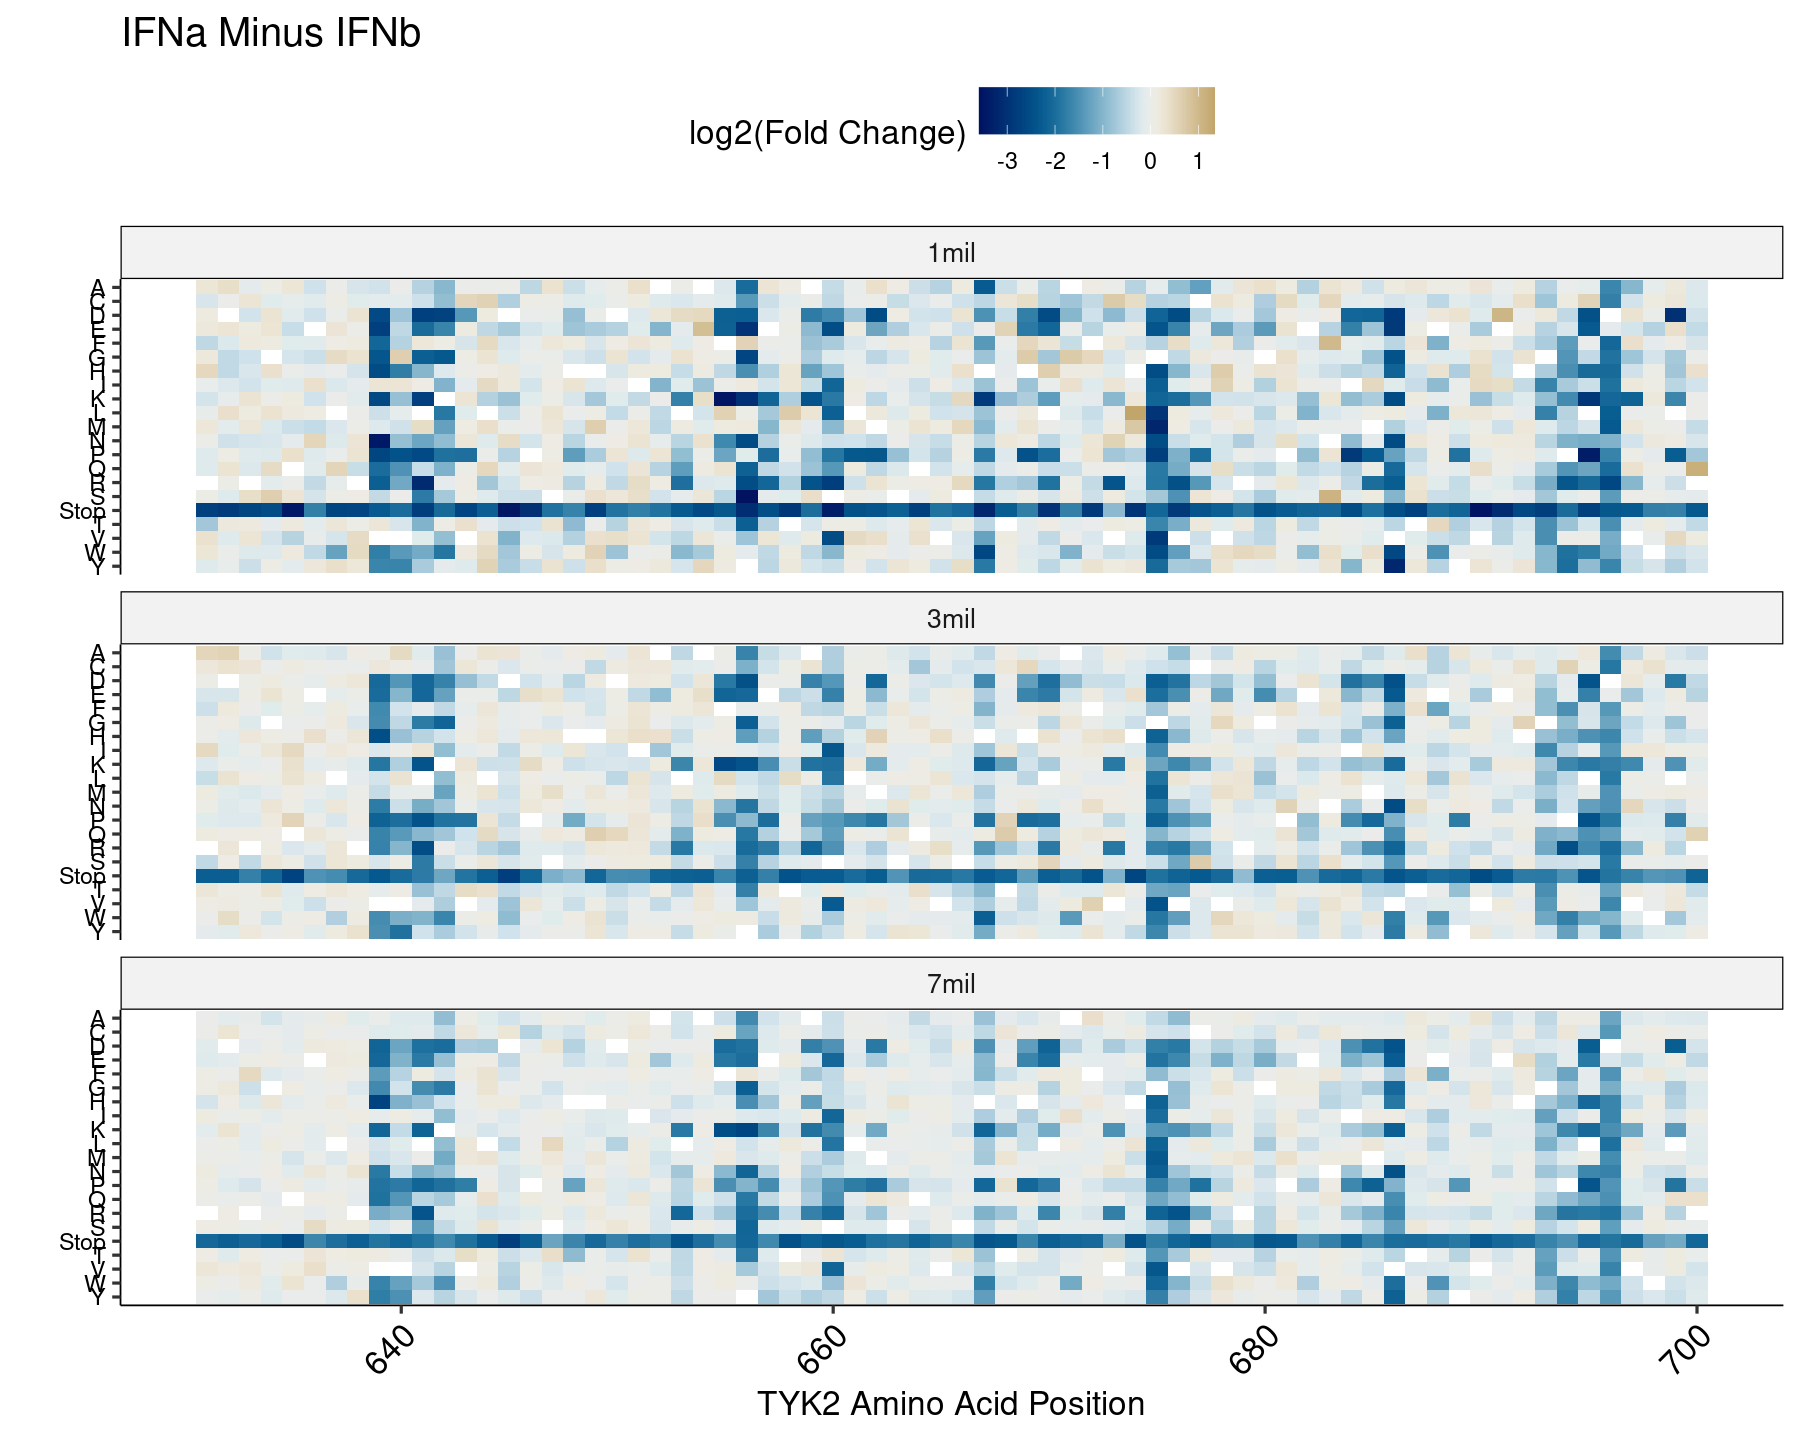

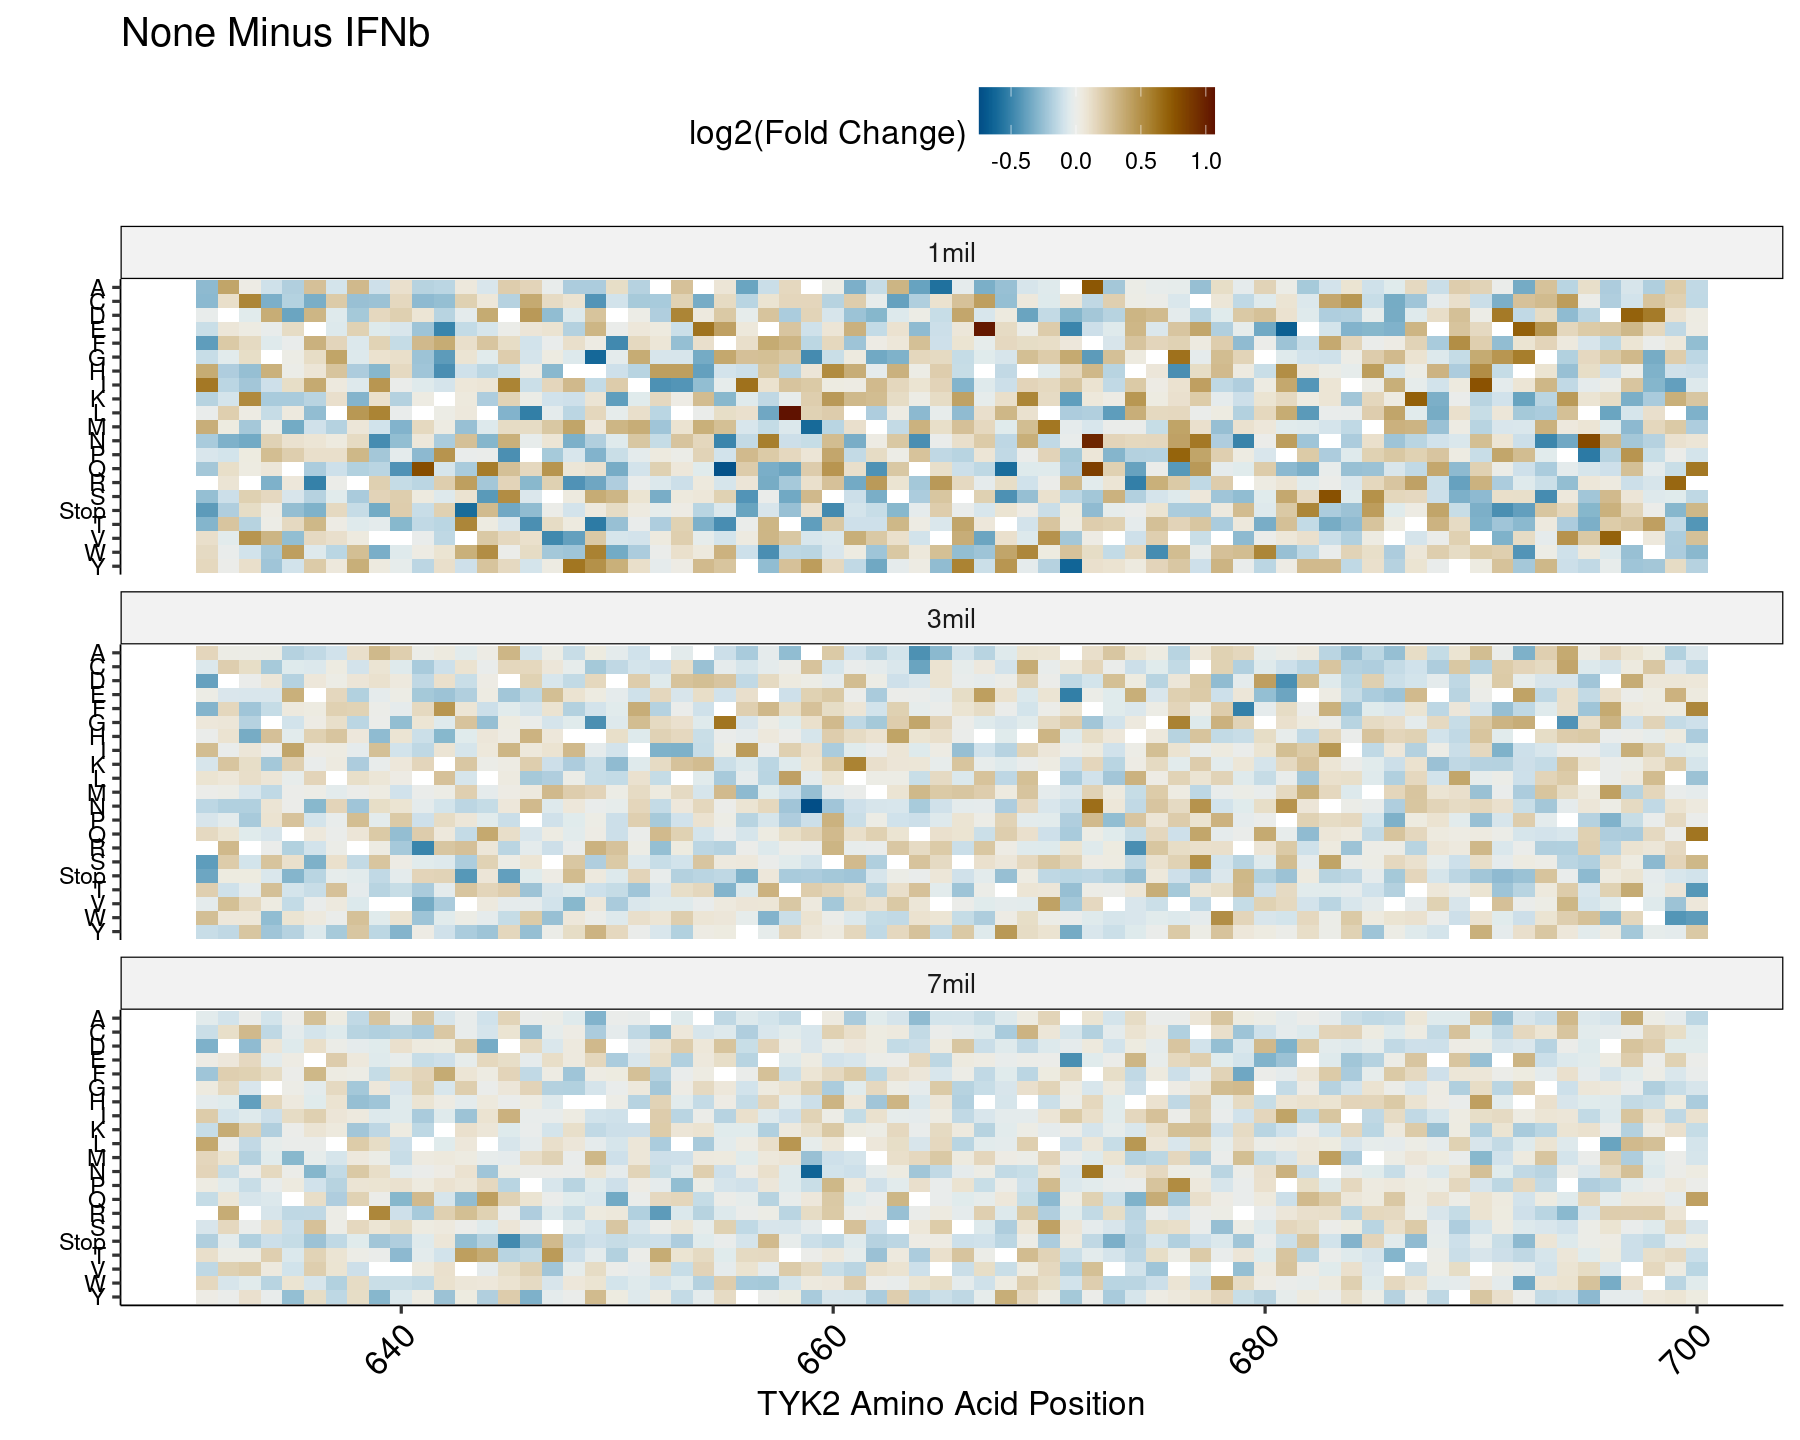

In [42]:
options(repr.plot.width = 15, repr.plot.height = 12)

sumstats_alpha_norm %>%
    mutate(mut_aa = if_else(mut_aa == "*", "Stop", mut_aa)) %>%
    rename("Z-statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = `Z-statistic`)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 20, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~density, ncol = 1) +
            ggtitle("IFNa Minus IFNb")

sumstats_none_norm %>%
    mutate(mut_aa = if_else(mut_aa == "*", "Stop", mut_aa)) %>%
    rename("Z-statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = `Z-statistic`)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 20, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~density, ncol = 1) +
            ggtitle("None Minus IFNb")

sumstats_alpha_norm %>%
    mutate(estimate = estimate / log(2),
           mut_aa = if_else(mut_aa == "*", "Stop", mut_aa)) %>%
    rename("log2(Fold Change)" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = `log2(Fold Change)`)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 20, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~density, ncol = 1) +
            ggtitle("IFNa Minus IFNb")

sumstats_none_norm %>%
    mutate(mut_aa = if_else(mut_aa == "*", "Stop", mut_aa)) %>%
    rename("log2(Fold Change)" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = `log2(Fold Change)`)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 20, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~density, ncol = 1) +
            ggtitle("None Minus IFNb")


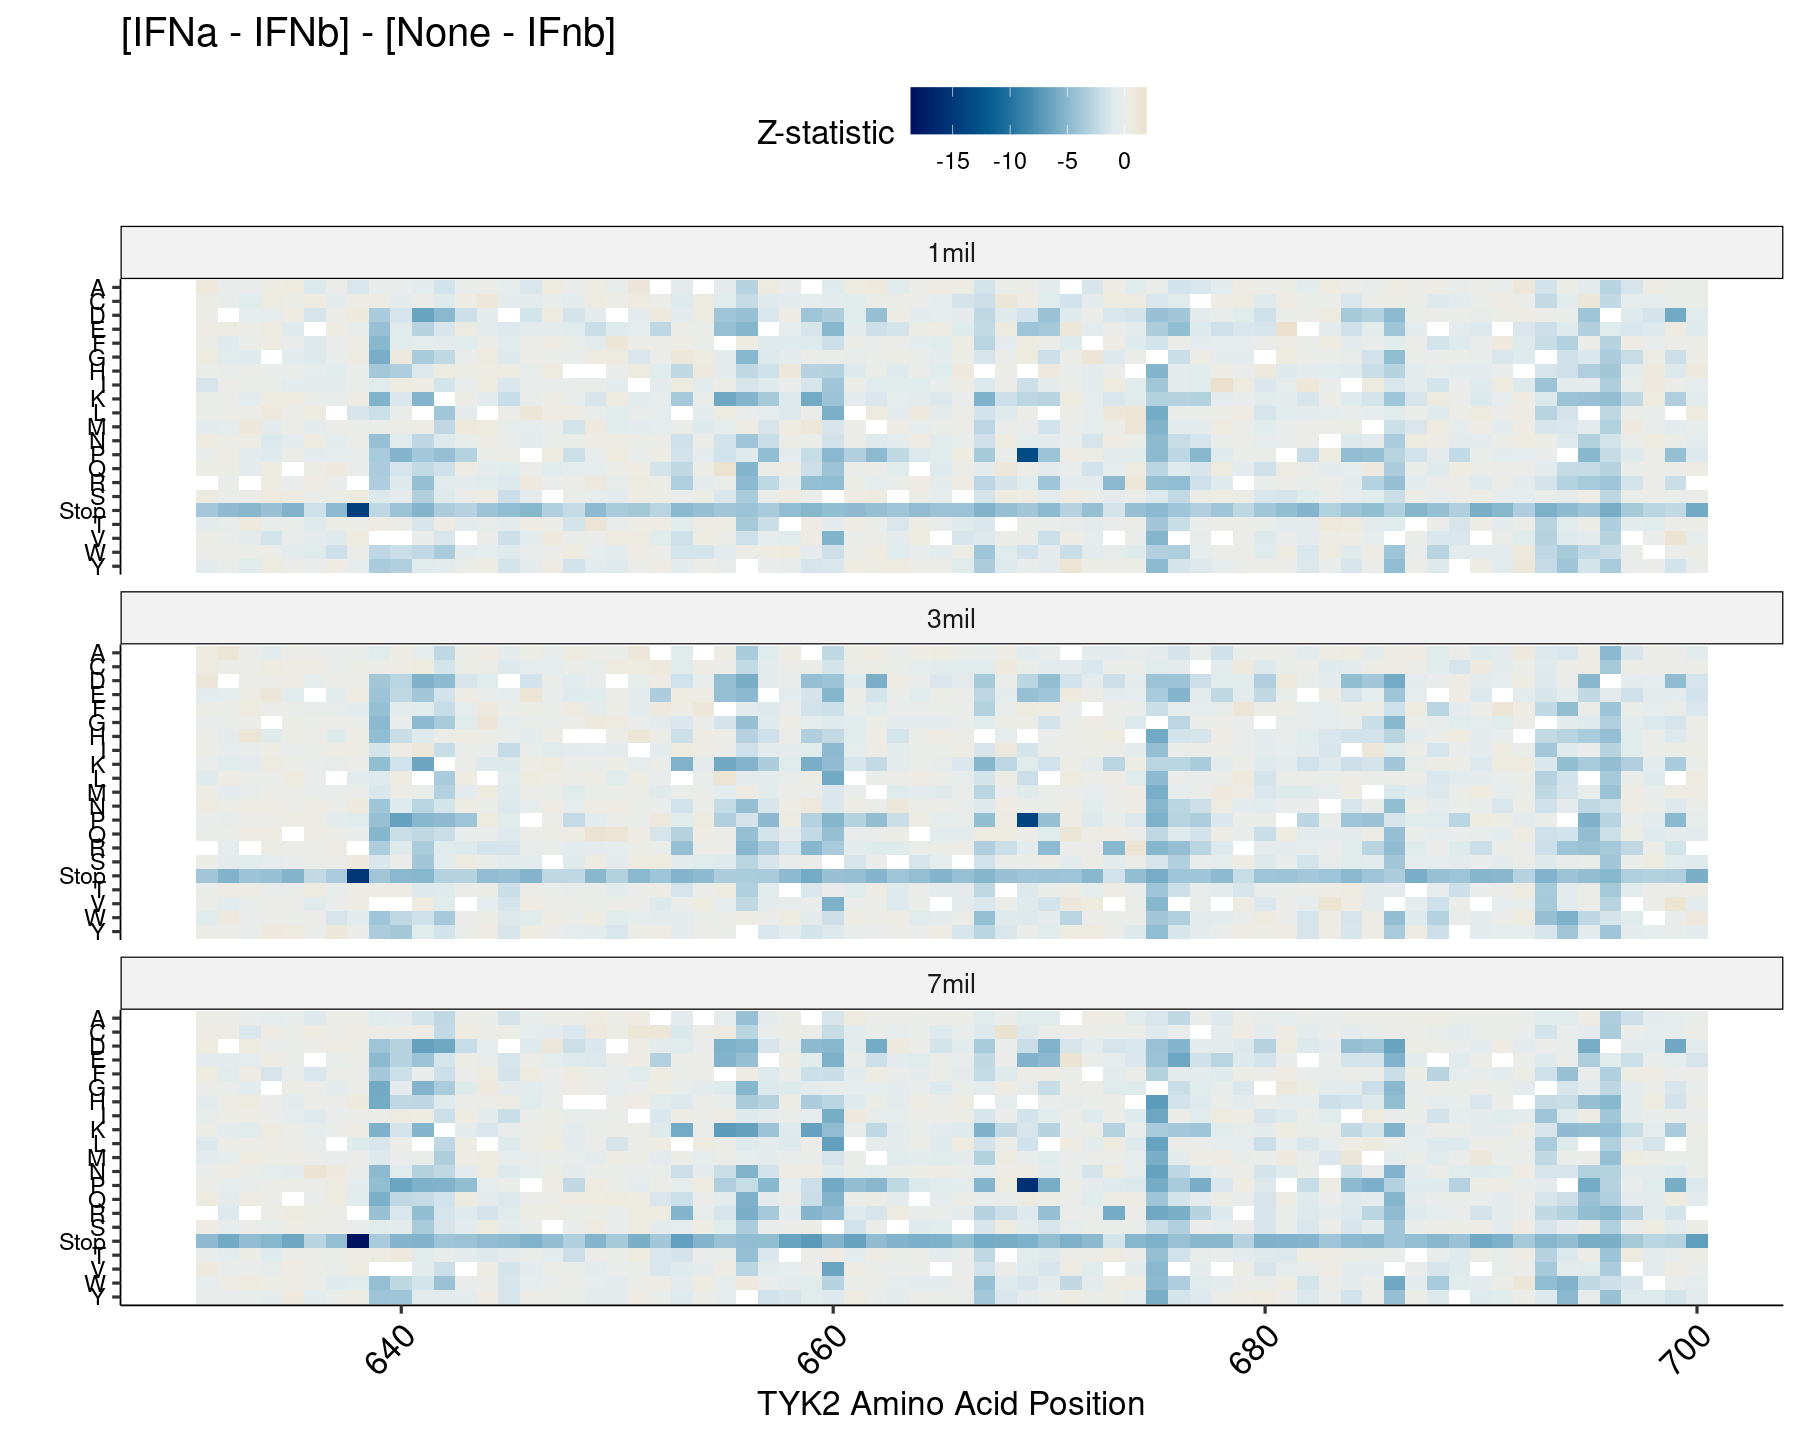

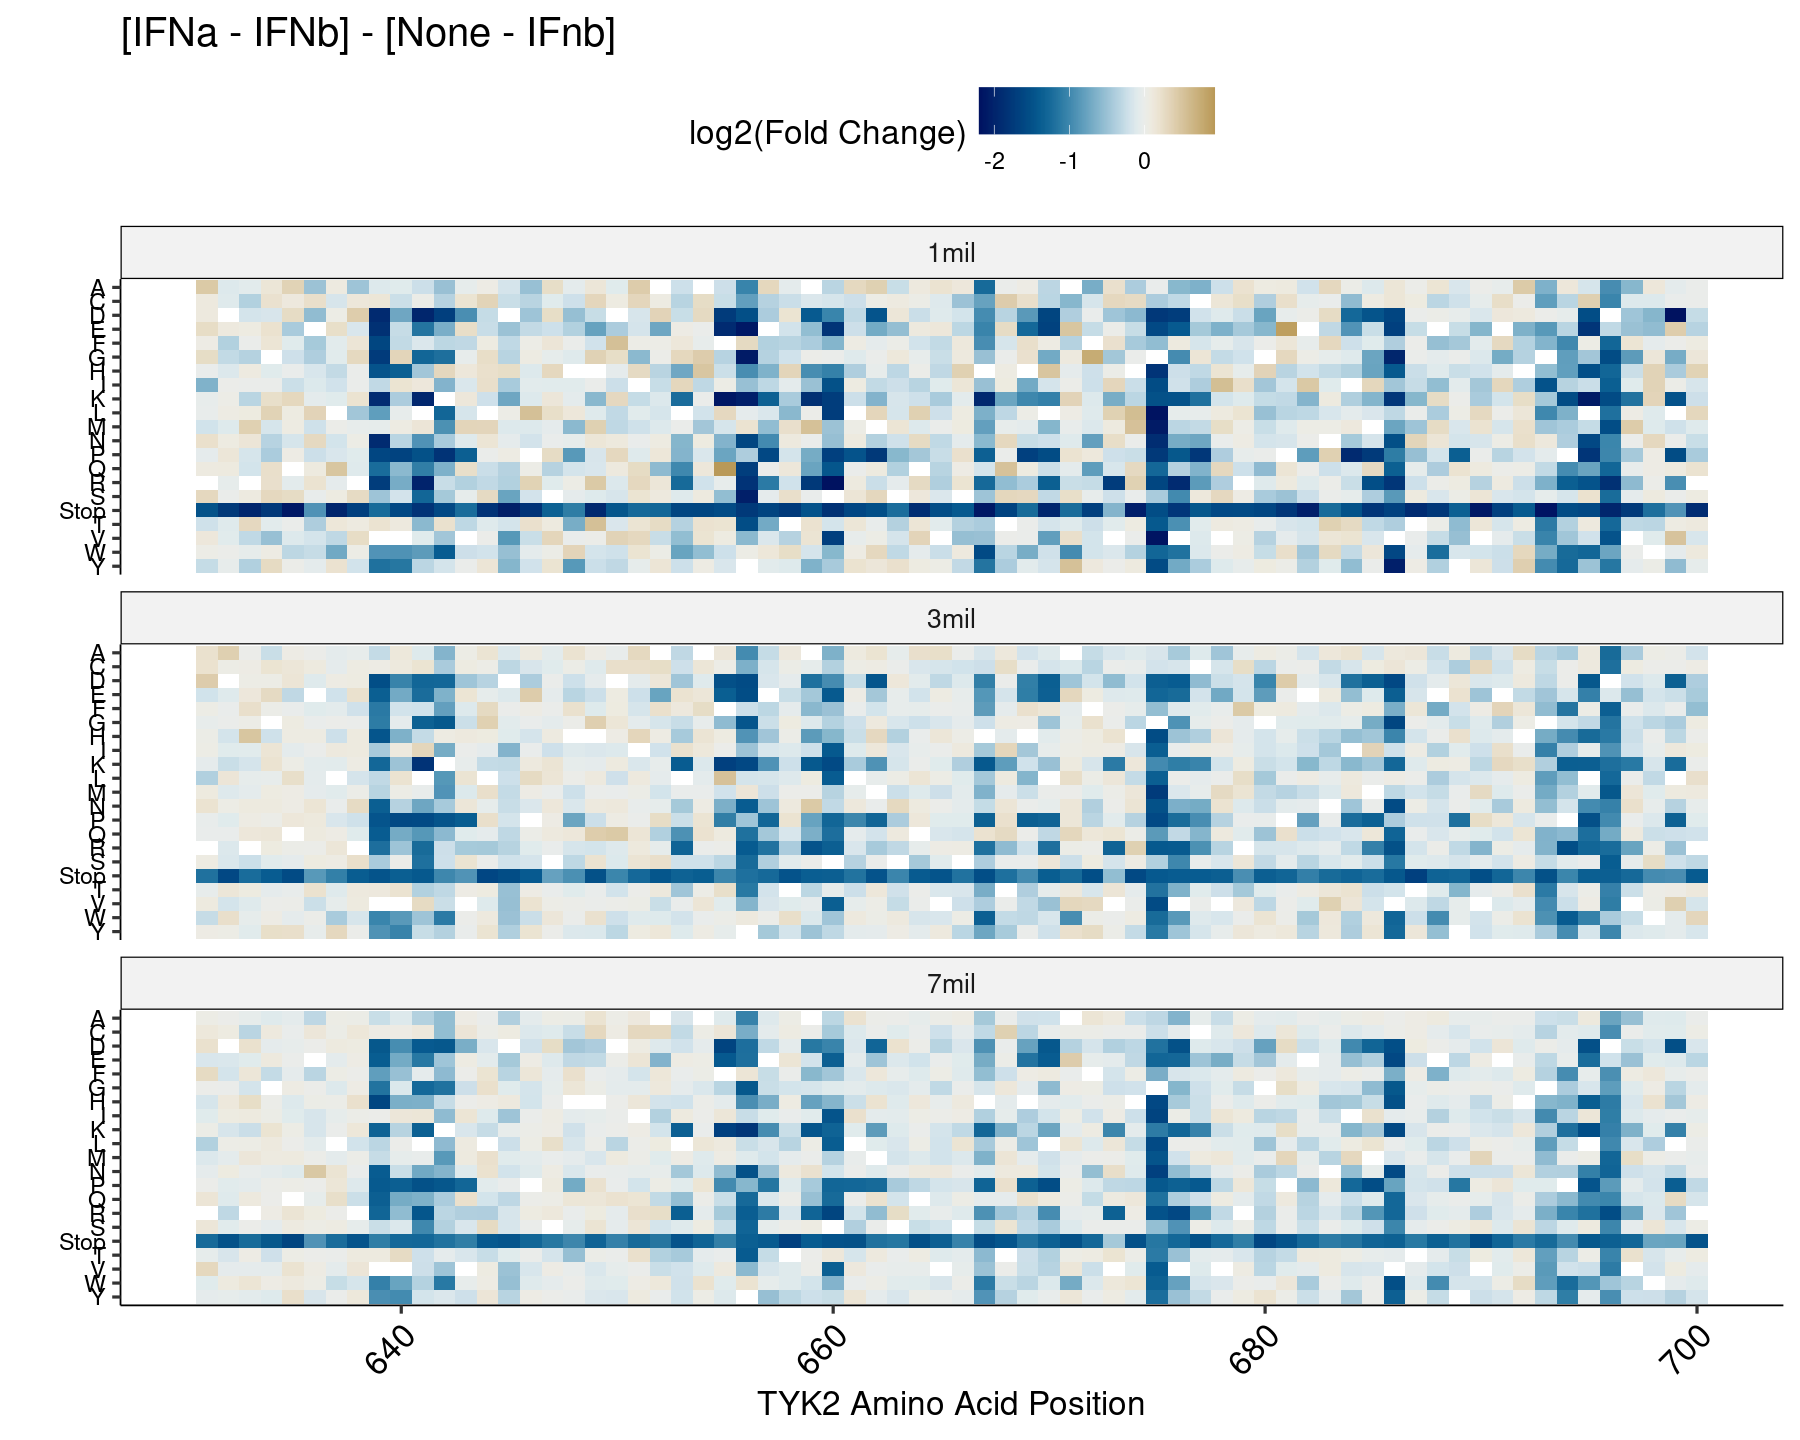

In [44]:
options(repr.plot.width = 15, repr.plot.height = 12)

sumstats_final_norm %>%
    mutate(mut_aa = if_else(mut_aa == "*", "Stop", mut_aa)) %>%
    rename("Z-statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = `Z-statistic`)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 20, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~density, ncol = 1) +
            ggtitle("[IFNa - IFNb] - [None - IFnb]")

sumstats_final_norm %>%
    mutate(mut_aa = if_else(mut_aa == "*", "Stop", mut_aa)) %>%
    rename("log2(Fold Change)" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(mut_aa), fill = `log2(Fold Change)`)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 20, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~density, ncol = 1) +
            ggtitle("[IFNa - IFNb] - [None - IFnb]")
